In [2]:
import torch

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from transformer_lens import HookedTransformer, HookedTransformerConfig
import transformer_lens.utils as utils

from tree_generation import *
from utils import *
from interp_utils import *
from probing import *
from sparse_coding import *

/media/victor/F8D25071D25035DA/Alingment/GraphPlanning/planning-in-transformers/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Model

Loading contents from file...


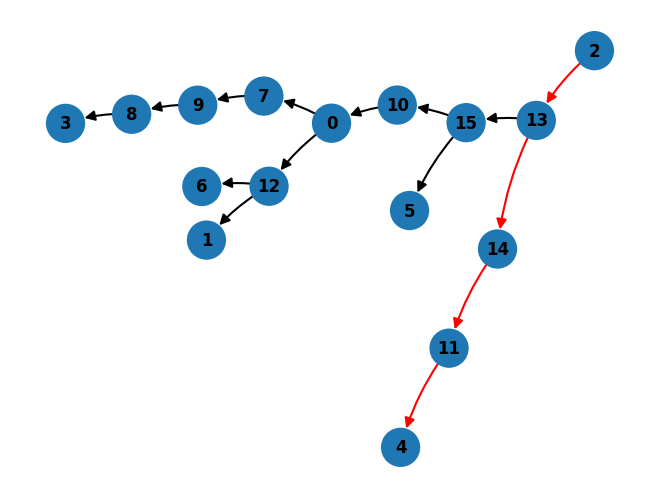

In [3]:
n_examples = 300_000
n_states = 16

dataset = GraphDataset(n_states, "dataset.txt", n_examples)
dataset.visualize_example(0)

In [4]:
cfg = HookedTransformerConfig(
    n_layers=6,
    d_model=128,
    n_ctx=dataset.max_seq_length - 1,
    n_heads=1,
    d_mlp=512,
    d_head=128,
    #attn_only=True,
    d_vocab=len(dataset.idx2tokens),
    device="cuda",
    attention_dir= "causal",
    act_fn="gelu",
)
model = HookedTransformer(cfg)


# Load in the model if weights are in the directory, else train new model
if os.path.exists("model.pt"):
    model.load_state_dict(torch.load("model.pt"))

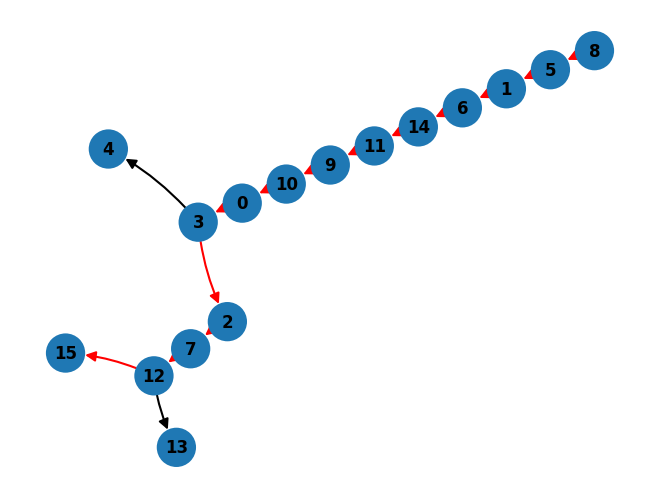

In [5]:
import random

random_seed = np.random.randint(1_000_000, 1_000_000_000)
pred = generate_example(n_states, random_seed, order="backward")
if is_model_correct(model, dataset, pred):
    parse_example(pred)
labels,cache = get_example_cache(pred, model, dataset)
labels= [f'N{i}_{component}' for i, component in enumerate(labels)]

In [6]:
for l in range(model.cfg.n_layers):
    for h in range(model.cfg.n_heads):
        fig = display_head(cache, labels, l, h, show=True)


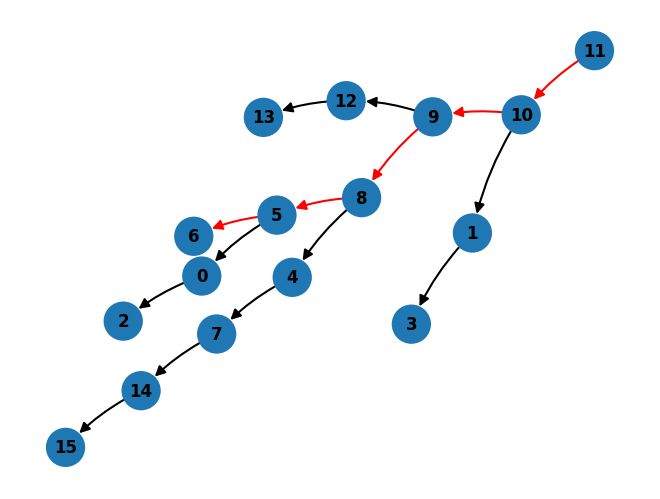

In [7]:
import random

random_seed = np.random.randint(1_000_000, 1_000_000_000)
pred = "14>15,0>2,7>14,5>6,5>0,4>7,12>13,8>5,8>4,9>12,9>8,1>3,10>9,10>1,11>10|6:11>10>9>8>5>6"
if is_model_correct(model, dataset, pred):
    parse_example(pred)
labels,cache = get_example_cache(pred, model, dataset)
labels= [f'N{i}_{component}' for i, component in enumerate(labels)]

In [8]:

for l in range(model.cfg.n_layers):
    for h in range(model.cfg.n_heads):
        fig = display_head(cache, labels, l, h, show=True)

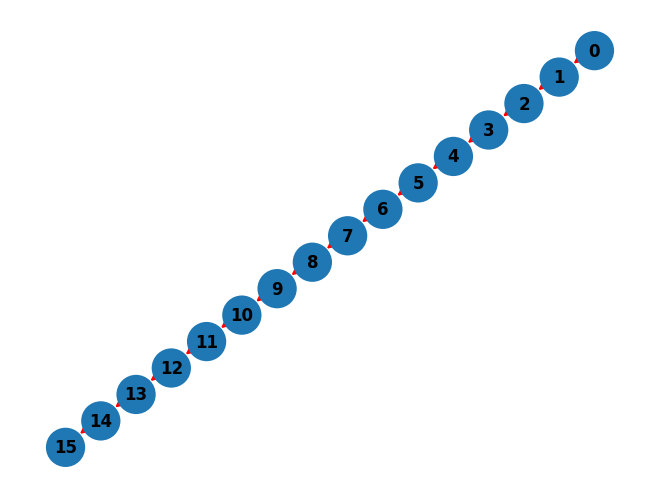

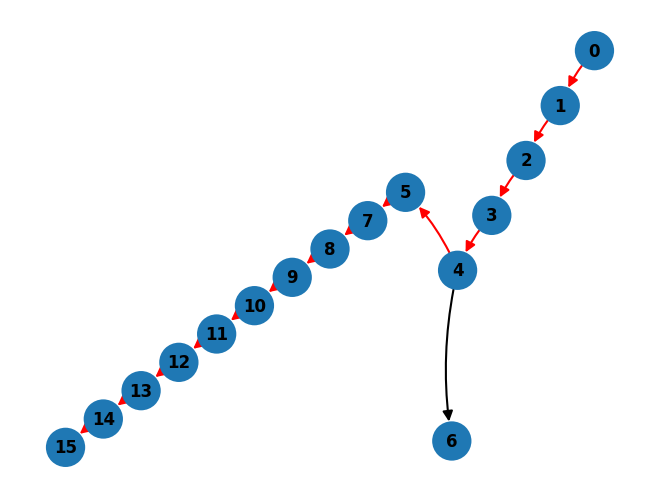

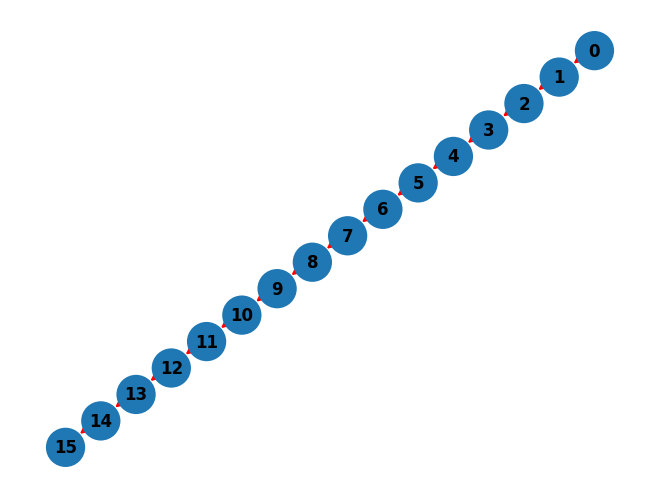

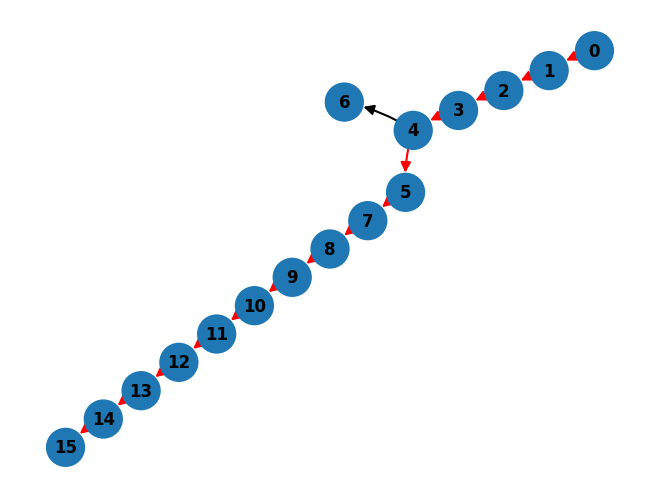

Clean logit difference: 26.328
Corrupted logit difference: -28.587
Positive Direction: >6
Negative Direction: >7


100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


Clean logit difference: 18.594
Corrupted logit difference: -23.263
Positive Direction: >6
Negative Direction: >7


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


In [9]:

clean_prompt = "0>1,1>2,2>3,3>4,4>5,5>6,6>7,7>8,8>9,9>10,10>11,11>12,12>13,13>14,14>15|15:0>1>2>3>4>5>6>7>8>9>10>11>12>13>14>15"

corrupted_prompt = "0>1,1>2,2>3,3>4,4>5,4>6,5>7,7>8,8>9,9>10,10>11,11>12,12>13,13>14,14>15|15:0>1>2>3>4>5>7>8>9>10>11>12>13>14>15"

parse_example(clean_prompt)
plt.show()
parse_example(corrupted_prompt)
plt.show()
# Tokenize
clean_tokens = torch.from_numpy(dataset.tokenize(clean_prompt)[0:-1]).cuda()
corrupted_tokens = torch.from_numpy(dataset.tokenize(corrupted_prompt)[0:-1]).cuda()


clean_prompt_backwards = "14>15,13>14,12>13,11>12,10>11,9>10,8>9,7>8,6>7,5>6,4>5,3>4,2>3,1>2,0>1|15:0>1>2>3>4>5>6>7>8>9>10>11>12>13>14>15"

corrupted_prompt_backwards = "14>15,13>14,12>13,11>12,10>11,9>10,8>9,7>8,5>7,4>6,4>5,3>4,2>3,1>2,0>1|15:0>1>2>3>4>5>7>8>9>10>11>12>13>14>15"

parse_example(clean_prompt_backwards)
plt.show()
parse_example(corrupted_prompt_backwards)
plt.show()
# Tokenize
clean_tokens_backwards  = torch.from_numpy(dataset.tokenize(clean_prompt_backwards )[0:-1]).cuda()
corrupted_tokens_backwards  = torch.from_numpy(dataset.tokenize(corrupted_prompt_backwards )[0:-1]).cuda()

patching_result = activation_patching(model, dataset, clean_tokens, corrupted_tokens, 46 + 7 )
patching_result_backwards  = activation_patching(model, dataset, clean_tokens_backwards , corrupted_tokens_backwards , 46 + 7 )

In [10]:
plot_activations(patching_result,clean_tokens,dataset)

In [11]:
plot_activations(patching_result_backwards,clean_tokens_backwards,dataset)

In [12]:

def activation_patching_register(model, dataset, clean_tokens, corrupted_tokens, comparison_index,positions):
    # We run on the clean prompt with the cache so we store activations to patch in later.
    clean_logits, clean_cache = model.run_with_cache(clean_tokens)
    clean_logit_diff = logits_to_logit_diff(clean_tokens, corrupted_tokens, clean_logits, comparison_index)
    print(f"Clean logit difference: {clean_logit_diff.item():.3f}")

    # We don't need to cache on the corrupted prompt.
    corrupted_logits = model(corrupted_tokens)
    corrupted_logit_diff = logits_to_logit_diff(clean_tokens, corrupted_tokens, corrupted_logits, comparison_index)
    print(f"Corrupted logit difference: {corrupted_logit_diff.item():.3f}")
    print(f"Positive Direction: {dataset.idx2tokens[clean_tokens[comparison_index]]}")
    print(f"Negative Direction: {dataset.idx2tokens[corrupted_tokens[comparison_index]]}")

    def residual_stream_patching_hook(
        resid_pre,
        hook,
        positions):
        # Each HookPoint has a name attribute giving the name of the hook.
        clean_resid_pre = clean_cache[hook.name]
        for position in positions:
            resid_pre[:, position, :] = clean_resid_pre[:, position, :]
        return resid_pre
    # We make a tensor to store the results for each patching run. We put it on the model's device to avoid needing to move things between the GPU and CPU, which can be slow.
    num_positions = clean_tokens.shape[0]
    patching_result = torch.zeros((model.cfg.n_layers), device=model.cfg.device)
    for layer in tqdm_auto.tqdm(range(model.cfg.n_layers)):
        # Use functools.partial to create a temporary hook function with the position fixed
        temp_hook_fn = partial(residual_stream_patching_hook, positions=positions)
        # Run the model with the patching hook
        patched_logits = model.run_with_hooks(corrupted_tokens, fwd_hooks=[
            (tl_util.get_act_name("resid_pre", layer), temp_hook_fn)
        ])
        # Calculate the logit difference
        patched_logit_diff = logits_to_logit_diff(clean_tokens, corrupted_tokens, patched_logits, comparison_index).detach()
        # Store the result, normalizing by the clean and corrupted logit difference so it's between 0 and 1 (ish)
        normalize_ratio = (clean_logit_diff - corrupted_logit_diff)
        if normalize_ratio == 0:
            normalize_ratio = 1
        patching_result[layer] = (patched_logit_diff - corrupted_logit_diff) / normalize_ratio
    return patching_result


def plot_activations(patching_result, clean_tokens, dataset):
    # Add the index to the end of the label, because plotly doesn't like duplicate labels
    token_labels = [f"{dataset.idx2tokens[token]}_{index}" for index, token in enumerate(clean_tokens)]
    imshow(patching_result, x=token_labels, xaxis="Position", yaxis="Layer", title="Activation patching")

In [13]:

def activation_patching_position_and_layers(model, dataset, clean_tokens, corrupted_tokens, comparison_index,positions,layers):
    # We run on the clean prompt with the cache so we store activations to patch in later.
    clean_logits, clean_cache = model.run_with_cache(clean_tokens)
    clean_logit_diff = logits_to_logit_diff(clean_tokens, corrupted_tokens, clean_logits, comparison_index)
    print(f"Clean logit difference: {clean_logit_diff.item():.3f}")

    # We don't need to cache on the corrupted prompt.
    corrupted_logits = model(corrupted_tokens)
    corrupted_logit_diff = logits_to_logit_diff(clean_tokens, corrupted_tokens, corrupted_logits, comparison_index)
    print(f"Corrupted logit difference: {corrupted_logit_diff.item():.3f}")
    print(f"Positive Direction: {dataset.idx2tokens[clean_tokens[comparison_index]]}")
    print(f"Negative Direction: {dataset.idx2tokens[corrupted_tokens[comparison_index]]}")

    def residual_stream_patching_hook(
        resid_pre,
        hook,
        positions):
        # Each HookPoint has a name attribute giving the name of the hook.
        clean_resid_pre = clean_cache[hook.name]
        for position in positions:
            resid_pre[:, position, :] = clean_resid_pre[:, position, :]
        return resid_pre
    # We make a tensor to store the results for each patching run. We put it on the model's device to avoid needing to move things between the GPU and CPU, which can be slow.
    num_positions = clean_tokens.shape[0]
    patching_result = 0
    # Use functools.partial to create a temporary hook function with the position fixed
    temp_hook_fn = partial(residual_stream_patching_hook, positions=positions)
    # Run the model with the patching hook
    hooks=[]
    for layer in layers:
        hooks.append((tl_util.get_act_name("resid_pre", layer), temp_hook_fn))

    patched_logits = model.run_with_hooks(corrupted_tokens, fwd_hooks=
            hooks
        )   
     
    # Calculate the logit difference
    patched_logit_diff = logits_to_logit_diff(clean_tokens, corrupted_tokens, patched_logits, comparison_index).detach()
    # Store the result, normalizing by the clean and corrupted logit difference so it's between 0 and 1 (ish)
    patching_result=0
    normalize_ratio = (clean_logit_diff - corrupted_logit_diff)
    if normalize_ratio == 0:
        normalize_ratio = 1
    patching_result = (patched_logit_diff - corrupted_logit_diff) / normalize_ratio
    return patching_result

In [14]:
model.reset_hooks()

In [15]:
clean_tokens = torch.from_numpy(dataset.tokenize(clean_prompt)[0:-1]).cuda()
corrupted_tokens = torch.from_numpy(dataset.tokenize(corrupted_prompt)[0:-1]).cuda()
patching_result = activation_patching_register(model, dataset, clean_tokens, corrupted_tokens, 46 + 7 ,[36,38,39,41,42,44,45])
patching_result_backwards = activation_patching_register(model, dataset, clean_tokens_backwards, corrupted_tokens_backwards, 46 + 7 ,[36,38,39,41,42,44,45])


Clean logit difference: 26.328
Corrupted logit difference: -28.587
Positive Direction: >6
Negative Direction: >7


100%|██████████| 6/6 [00:00<00:00, 42.39it/s]

Clean logit difference: 18.594


Corrupted logit difference: -23.263
Positive Direction: >6
Negative Direction: >7


100%|██████████| 6/6 [00:00<00:00, 49.46it/s]


In [16]:
imshow([patching_result])

In [17]:
imshow([patching_result_backwards])

In [18]:
patching_result_backwards_layers=activation_patching_position_and_layers(model, dataset, clean_tokens_backwards, corrupted_tokens_backwards, 46 + 7 ,[36,38,39,41,42,44,45],[0,1,2,3,4,5])#[36,38,39,41,42,44,45],[0,1,2,3,4,5])
patching_result_backwards_layers

Clean logit difference: 18.594
Corrupted logit difference: -23.263
Positive Direction: >6
Negative Direction: >7


tensor(-0.0091, device='cuda:0', grad_fn=<DivBackward0>)

In [19]:
patching_result_backwards_layers=activation_patching_position_and_layers(model, dataset, clean_tokens_backwards, corrupted_tokens_backwards, 46 + 7 ,[36,38,39,41,42,44,45,46,47],[0,1,2,3,4,5])#[36,38,39,41,42,44,45],[0,1,2,3,4,5])
patching_result_backwards_layers

Clean logit difference: 18.594
Corrupted logit difference: -23.263
Positive Direction: >6
Negative Direction: >7


tensor(0.0190, device='cuda:0', grad_fn=<DivBackward0>)

In [20]:
def activation_patching_layers(model, dataset, clean_tokens, corrupted_tokens, comparison_index,layers):
    # We run on the clean prompt with the cache so we store activations to patch in later.
    clean_logits, clean_cache = model.run_with_cache(clean_tokens)
    clean_logit_diff = logits_to_logit_diff(clean_tokens, corrupted_tokens, clean_logits, comparison_index)
    print(f"Clean logit difference: {clean_logit_diff.item():.3f}")

    # We don't need to cache on the corrupted prompt.
    corrupted_logits = model(corrupted_tokens)
    corrupted_logit_diff = logits_to_logit_diff(clean_tokens, corrupted_tokens, corrupted_logits, comparison_index)
    print(f"Corrupted logit difference: {corrupted_logit_diff.item():.3f}")
    print(f"Positive Direction: {dataset.idx2tokens[clean_tokens[comparison_index]]}")
    print(f"Negative Direction: {dataset.idx2tokens[corrupted_tokens[comparison_index]]}")

    def residual_stream_patching_hook(
        resid_pre,
        hook,
        position):
        # Each HookPoint has a name attribute giving the name of the hook.
        clean_resid_pre = clean_cache[hook.name]
        resid_pre[:, position, :] = clean_resid_pre[:, position, :]
        return resid_pre
    # We make a tensor to store the results for each patching run. We put it on the model's device to avoid needing to move things between the GPU and CPU, which can be slow.
    num_positions = clean_tokens.shape[0]
    patching_result = torch.zeros(num_positions, device=model.cfg.device)
    for position in range(num_positions):
            # Use functools.partial to create a temporary hook function with the position fixed
            temp_hook_fn = partial(residual_stream_patching_hook, position=position)
            # Run the model with the patching hook
            hooks=[]
            for layer in layers:
                hooks.append((tl_util.get_act_name("resid_pre", layer), temp_hook_fn))
            
            patched_logits = model.run_with_hooks(corrupted_tokens, fwd_hooks=hooks)
            # Calculate the logit difference
            patched_logit_diff = logits_to_logit_diff(clean_tokens, corrupted_tokens, patched_logits, comparison_index).detach()
            # Store the result, normalizing by the clean and corrupted logit difference so it's between 0 and 1 (ish)
            normalize_ratio = (clean_logit_diff - corrupted_logit_diff)
            if normalize_ratio == 0:
                normalize_ratio = 1
            patching_result[position] = (patched_logit_diff - corrupted_logit_diff) / normalize_ratio
    return patching_result

In [21]:
def delete_non_paths(input_dict):
    keys_to_delete = [key for key, value in input_dict.items() if len(value) <= 2]
    for key in keys_to_delete:
        del input_dict[key]
    return input_dict

special_chars = [",", ":", "|"]
def get_paths(cache, labels, threshold=0.6):

    paths = {}
    for layer in range(1, 6):
        attn_pattern = cache[f"blocks.{layer}.attn.hook_pattern"]
        _, _, seq_len, _ = attn_pattern.shape

        for current_pos in range(seq_len):       
            current_token = labels[current_pos]     
            for attended_pos in range(seq_len):
                attn_value = attn_pattern[0, 0, current_pos, attended_pos]
                if attn_value > threshold:
                    attended_token = labels[attended_pos].replace(">", "")
                    previous_token = labels[attended_pos - 1].replace(">", "")
                    if not attended_token in special_chars and not previous_token in special_chars:
                        identifier = (current_pos, current_token)
                        if identifier in paths.keys():
                            paths[identifier].append(previous_token)
                        else:
                            paths[identifier] = [attended_token, previous_token]
    
    paths = delete_non_paths(paths)
    return paths

In [22]:
#clean_prompt_test="8>14,8>9,5>11,5>2,10>8,10>5,1>4,6>15,6>10,0>1,12>6,12>0,3>13,7>12,7>3|11:7>12>6>10>5>11"
#corrupted_prompt_test="8>14,8>9,5>11,5>2,10>8,10>5,1>4,6>15,6>10,0>1,3>6,3>0,12>13,7>3,7>12|11:7>3>6>10>5>11"
#clean_prompt_test="15>14,8>9,5>11,5>2,10>8,10>5,1>4,7>15,6>10,0>1,12>6,12>0,3>13,7>12,7>3|11:7>12>6>10>5>11"
#corrupted_prompt_test="15>14,8>9,5>11,5>2,10>8,10>5,1>4,7>15,6>10,0>1,3>6,3>0,12>13,7>3,7>12|11:7>3>6>10>5>11"
clean_prompt_test="15>14,7>9,5>11,9>2,10>8,10>5,1>4,7>15,6>10,0>1,12>6,12>0,3>13,7>12,7>3|11:7>12>6>10>5>11"
corrupted_prompt_test="15>14,7>9,5>11,9>2,10>8,10>5,1>4,7>15,6>10,0>1,3>6,3>0,12>13,7>3,7>12|11:7>3>6>10>5>11"

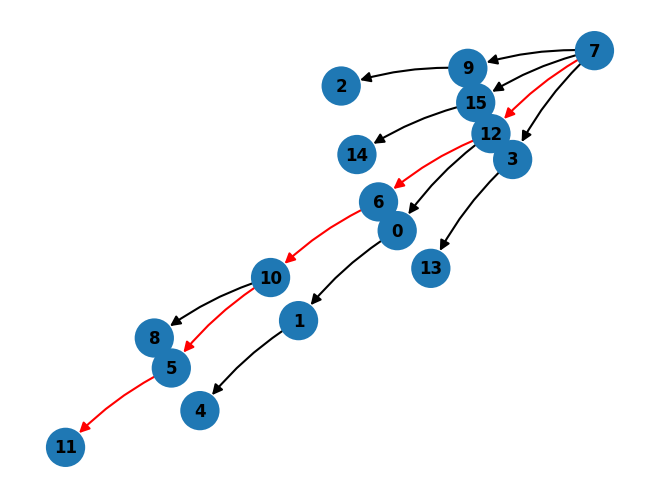

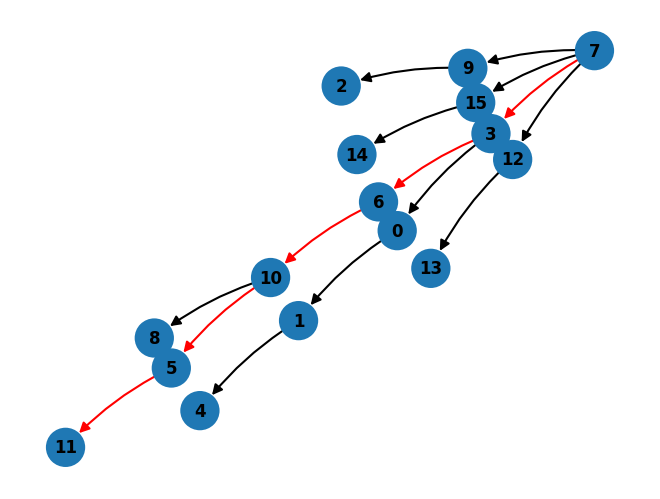

In [23]:
parse_example(clean_prompt_test)
plt.show()
parse_example(corrupted_prompt_test)
plt.show()

In [24]:
clean_tokens_backwards_test = torch.from_numpy(dataset.tokenize(clean_prompt_test)[0:-1]).cuda()
corrupted_tokens_backwards_test= torch.from_numpy(dataset.tokenize(corrupted_prompt_test)[0:-1]).cuda()
labels, cache = get_example_cache(clean_prompt_test, model, dataset)
subpaths_clean = get_paths(cache, labels)
print(f'subpaths clean:{subpaths_clean}')
labels, cache = get_example_cache(corrupted_prompt_test, model, dataset)
subpaths_corrupted = get_paths(cache, labels)
print(f'subpaths corrupted:{subpaths_corrupted}')

subpaths clean:{(38, ','): ['10', '6', '12'], (44, '|'): ['1', '0', '12'], (47, '7'): ['11', '5', '10'], (48, '>12'): ['11', '5', '10'], (49, '>6'): ['11', '5', '10'], (50, '>10'): ['11', '5', '10', '6'], (51, '>5'): ['11', '5', '10', '10'], (52, '>11'): ['11', '5', '5']}
subpaths corrupted:{(38, ','): ['10', '6', '3'], (44, '|'): ['1', '0', '3', '7'], (47, '7'): ['11', '5', '10'], (48, '>3'): ['11', '5', '10'], (49, '>6'): ['11', '5', '10'], (50, '>10'): ['11', '5', '10', '6'], (51, '>5'): ['11', '5', '10', '10'], (52, '>11'): ['11', '5', '5'], (42, '7'): ['10', '6', '3'], (46, ':'): ['6', '3', '7']}


In [25]:
clean_tokens_backwards_test = torch.from_numpy(dataset.tokenize(clean_prompt_test)[0:-1]).cuda()
corrupted_tokens_backwards_test= torch.from_numpy(dataset.tokenize(corrupted_prompt_test)[0:-1]).cuda()
register_patching_result_backwards_test = activation_patching_register(model, dataset, clean_tokens_backwards_test, corrupted_tokens_backwards_test, 46 + 2 ,[36,38,39,41,42,44,45])

Clean logit difference: 22.105
Corrupted logit difference: -25.266
Positive Direction: >12
Negative Direction: >3


  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 55.74it/s]


In [26]:
imshow(model(clean_tokens_backwards_test)[0])

In [27]:
imshow(model(corrupted_tokens_backwards_test)[0])

In [28]:
model.reset_hooks()
clean_logits, clean_cache = model.run_with_cache(clean_tokens_backwards_test)
def residual_stream_patching_hook(
        resid_pre,
        hook,
        positions):
        # Each HookPoint has a name attribute giving the name of the hook.
        clean_resid_pre = clean_cache[hook.name]
        for position in positions:
            resid_pre[:, position, :] = clean_resid_pre[:, position, :]
        return resid_pre
    # We make a tensor to store the results for each patching run. We put it on the model's device to avoid needing to move things between the GPU and CPU, which can be slow.

temp_hook = partial(residual_stream_patching_hook, positions=[38])#[36,38,39,41,42,44,45])
# Run the model with the patching hook
patched_logits = model.run_with_hooks(corrupted_tokens_backwards_test, fwd_hooks=[
            (tl_util.get_act_name("resid_pre", 3), temp_hook),(tl_util.get_act_name("resid_pre", 4), temp_hook)
        ])
model.reset_hooks()

In [29]:
imshow(patched_logits[0])

In [30]:
imshow(torch.softmax(patched_logits[0],1)[47:49])

In [31]:
imshow(clean_logits[0][47:49])

In [32]:
imshow(torch.softmax(clean_logits[0],1)[47:49])

In [33]:
imshow((torch.softmax(clean_logits[0],1)-torch.softmax(patched_logits[0],1))[47:49])

In [34]:
register_patching_result_backwards_test = activation_patching_register(model, dataset, clean_tokens_backwards_test, corrupted_tokens_backwards_test, 46 + 2 ,[36,38,39,41,42,44,45])

Clean logit difference: 22.105
Corrupted logit difference: -25.266
Positive Direction: >12
Negative Direction: >3


  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 53.53it/s]


In [35]:
imshow([register_patching_result_backwards_test])

In [36]:
patching_result_backwards_test = activation_patching(model, dataset, clean_tokens_backwards_test, corrupted_tokens_backwards_test, 46 + 2)

Clean logit difference: 22.105
Corrupted logit difference: -25.266
Positive Direction: >12
Negative Direction: >3


  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


In [37]:
plot_activations(patching_result_backwards_test, clean_tokens_backwards_test, dataset)


In [38]:
patching_result_backwards_layers=activation_patching_layers(model, dataset, clean_tokens_backwards, corrupted_tokens_backwards, 46 + 7 ,[0,1,2,3,4,5])#[36,38,39,41,42,44,45],[0,1,2,3,4,5])
plot_activations([patching_result_backwards_layers], clean_tokens, dataset)

Clean logit difference: 18.594
Corrupted logit difference: -23.263
Positive Direction: >6
Negative Direction: >7


# Patching Result

In [39]:
def replace_nodes(graph,n1,n2):
    replace_A_1=graph.replace(f">{n1},",">A,")
    replace_A_2=replace_A_1.replace(f",{n1}>",",A>")
    replace_A_3=replace_A_2.replace(f">{n1}>",">A>")
    replace_A_4=replace_A_3.replace(f">{n1}|",">A|")
    replace_n1_1=replace_A_4.replace(f">{n2},",f">{n1},")
    replace_n1_2=replace_n1_1.replace(f",{n2}>",f",{n1}>")
    replace_n1_3=replace_n1_2.replace(f">{n2}>",f">{n1}>")
    replace_n1_4=replace_n1_3.replace(f">{n2}|",f">{n1}|")
    replace_n2=replace_n1_4.replace("A",f"{n2}")
    return replace_n2
    #Doesnt replace first node in list

In [40]:
random_seed = np.random.randint(1_000_000, 1_000_000_000)
graph = generate_example(n_states, random_seed, order="backward")
full_path = graph.split(":")[1].split(">")[1:]  # we ignore the first position, might need to reconsider this at some point


In [41]:
'7>2,10>7,14>10,8>14,0>8,6>0,9>6,11>9,3>11,12>3,1>12,15>1,5>13,4>15,4>5|2:4>15>1>12>3>11>9>6>0>8>14>10>7>2'

'7>2,10>7,14>10,8>14,0>8,6>0,9>6,11>9,3>11,12>3,1>12,15>1,5>13,4>15,4>5|2:4>15>1>12>3>11>9>6>0>8>14>10>7>2'

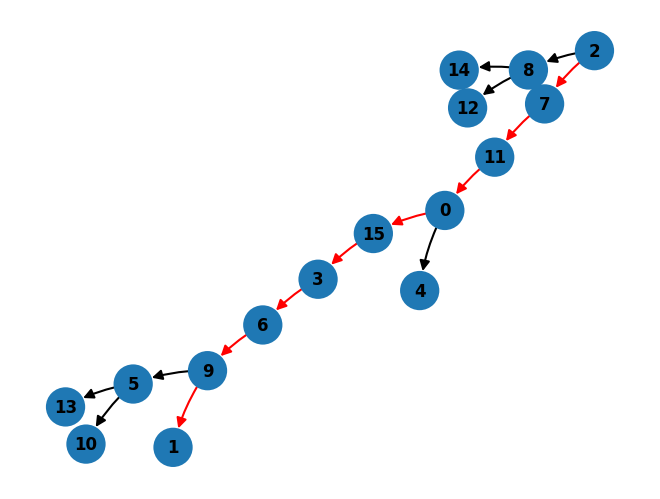

In [42]:
parse_example(graph)

In [43]:
corrupted_graph= replace_nodes(graph,13,10)

In [44]:
corrupted_graph

'5>10,5>13,9>5,9>1,6>9,3>6,15>3,0>15,0>4,11>0,8>14,8>12,7>11,2>8,2>7|1:2>7>11>0>15>3>6>9>1'

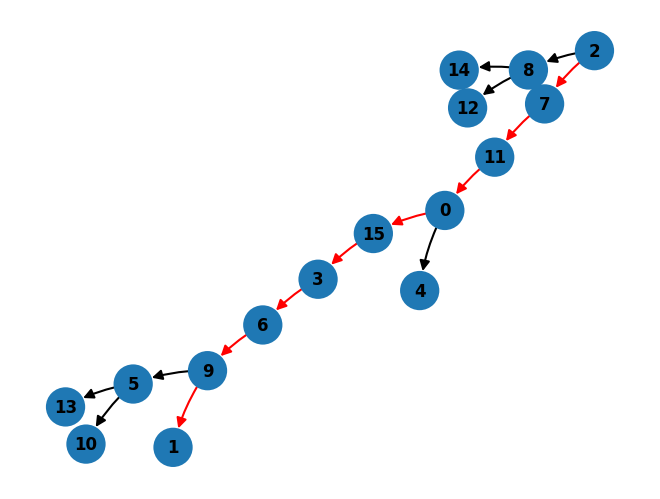

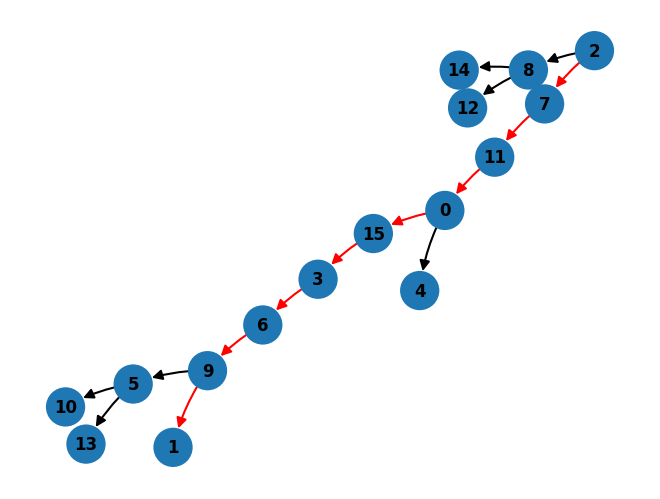

In [45]:
parse_example(graph)
plt.show()
parse_example(corrupted_graph)
plt.show()

In [46]:
model.reset_hooks()
position=46 + 5
clean_graph_tokens = torch.from_numpy(dataset.tokenize(graph)[0:-1]).cuda()
clean_logits, clean_cache = model.run_with_cache(clean_graph_tokens)
print( dataset.untokenize(np.argmax(clean_logits.detach().cpu(),2)[0][47:]))
corrupted_graph_tokens= torch.from_numpy(dataset.tokenize(corrupted_graph)[0:-1]).cuda()
corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_graph_tokens)
activation_patching_result=activation_patching(model, dataset, clean_graph_tokens,corrupted_graph_tokens , position)#46 + 2
register_pathcing_result= activation_patching_register(model, dataset, clean_graph_tokens,corrupted_graph_tokens , position,[36,38,39,41,42,44,45])




>7>11>0>15>3>6>9>1
Clean logit difference: 0.000
Corrupted logit difference: 0.000
Positive Direction: >15
Negative Direction: >15


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Clean logit difference: 0.000
Corrupted logit difference: 0.000
Positive Direction: >15
Negative Direction: >15


100%|██████████| 6/6 [00:00<00:00, 49.52it/s]


In [47]:
labels, cache = get_example_cache(graph, model, dataset)
get_paths(clean_cache,labels)

{(36, '7'): ['6', '3', '15', '0'],
 (38, ','): ['10', '5', '9', '6'],
 (39, '2'): ['3', '15', '0', '11'],
 (41, ','): ['0', '11', '7'],
 (44, '|'): ['5', '9', '6'],
 (45, '1'): ['0', '11', '7'],
 (46, ':'): ['9', '6', '3', '15'],
 (47, '2'): ['1', '9', '6'],
 (48, '>7'): ['1', '9', '6'],
 (49, '>11'): ['1', '9', '6'],
 (50, '>0'): ['1', '9', '6'],
 (51, '>15'): ['1', '9', '6'],
 (52, '>3'): ['1', '9', '6'],
 (53, '>6'): ['1', '9', '6', '3'],
 (54, '>9'): ['1', '9', '6'],
 (55, '>1'): ['1', '9', '9']}

In [48]:
imshow([register_pathcing_result[1:]],x=list(range(1,model.cfg.n_layers)))

In [49]:
imshow([register_pathcing_result[1:]],x=list(range(1,model.cfg.n_layers)))

In [50]:
plot_activations(activation_patching_result,clean_graph_tokens, dataset)

In [51]:
plot_activations(activation_patching_result,clean_graph_tokens, dataset)

# Test leaf

In [52]:

graph_not_leaf='7>2,10>7,14>10,8>14,0>8,6>0,9>6,11>9,3>11,12>3,1>12,15>1,5>13,4>15,4>5|2:4>15>1>12>3>11>9>6>0>8>14>10>7>2'
graph_leaf='7>2,10>7,14>10,8>14,0>8,6>0,9>6,11>9,3>11,12>3,1>12,15>1,4>13,4>15,4>5|2:4>15>1>12>3>11>9>6>0>8>14>10>7>2'

corrupted_graph_not_leaf= replace_nodes(graph_not_leaf,15,5)
corrupted_graph_leaf= replace_nodes(graph_leaf,15,5)


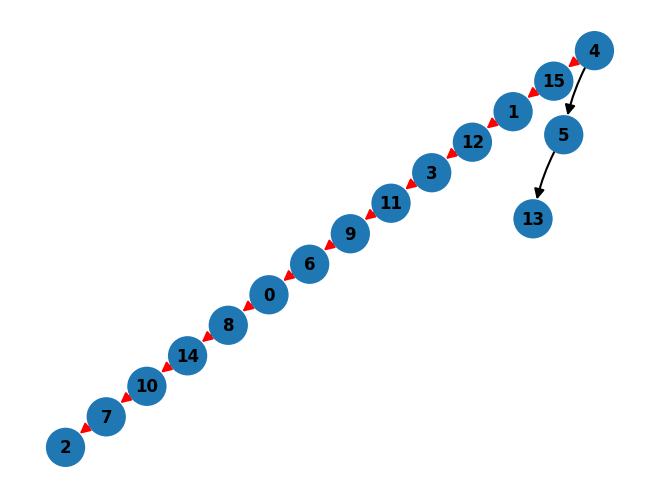

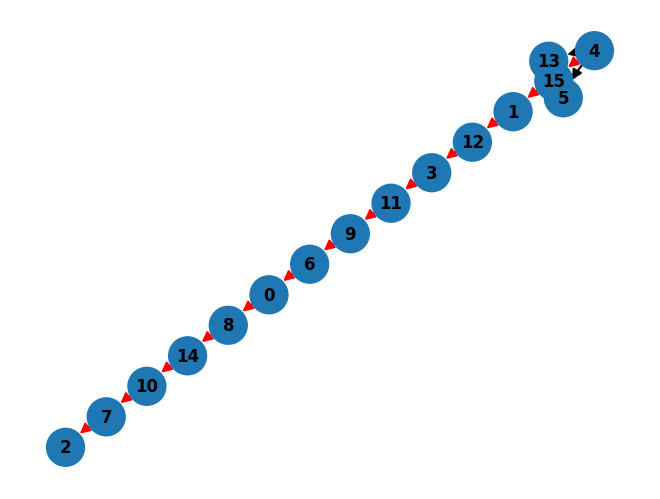

In [53]:
parse_example(graph_not_leaf)
plt.show()
parse_example(graph_leaf)
plt.show()

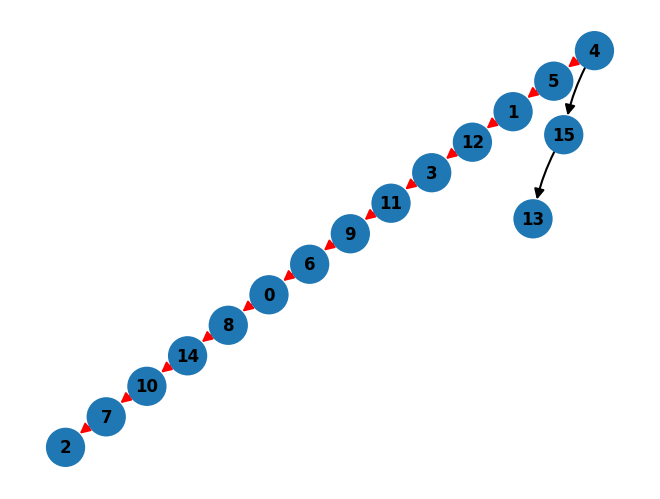

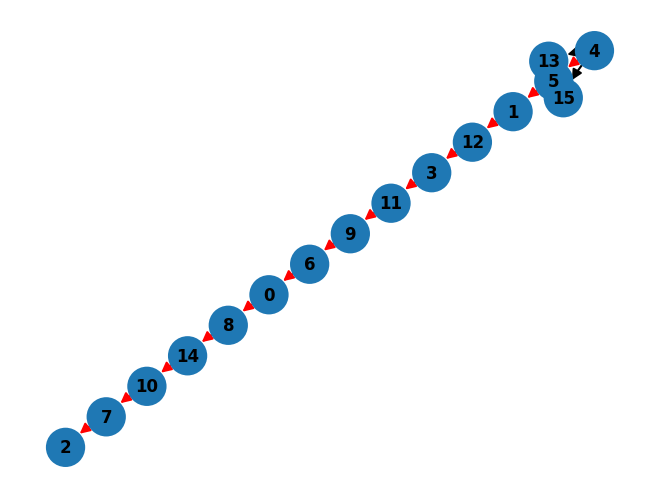

In [54]:
parse_example(corrupted_graph_not_leaf)
plt.show()
parse_example(corrupted_graph_leaf)
plt.show()

In [55]:
model.reset_hooks()
position=46 + 2
clean_graph_leaf_tokens = torch.from_numpy(dataset.tokenize(graph_leaf)[0:-1]).cuda()
clean_logits_leaf, clean_cache_leaf = model.run_with_cache(clean_graph_leaf_tokens)
print( dataset.untokenize(np.argmax(clean_logits_leaf.detach().cpu(),2)[0][47:]))
corrupted_graph_leaf_tokens= torch.from_numpy(dataset.tokenize(corrupted_graph_leaf)[0:-1]).cuda()
corrupted_logits_leaf, corrupted_cache_leaf = model.run_with_cache(corrupted_graph_leaf_tokens)
activation_patching_result_leaf=activation_patching(model, dataset, clean_graph_leaf_tokens,corrupted_graph_leaf_tokens , position)#46 + 2
register_pathcing_result_leaf= activation_patching_register(model, dataset, clean_graph_leaf_tokens,corrupted_graph_leaf_tokens , position,[36,38,39,41,42,44,45])




>15>1>12>3>11>9>6>0>8>14>10>7>2
Clean logit difference: 16.614
Corrupted logit difference: -18.238
Positive Direction: >15
Negative Direction: >5


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Clean logit difference: 16.614
Corrupted logit difference: -18.238
Positive Direction: >15
Negative Direction: >5


100%|██████████| 6/6 [00:00<00:00, 60.60it/s]


In [56]:
plot_activations(activation_patching_result_leaf,clean_graph_leaf_tokens, dataset)

In [57]:
imshow([register_pathcing_result_leaf[1:]],x=list(range(1,model.cfg.n_layers)))

In [58]:
model.reset_hooks()
position=46 + 2  
clean_graph_not_leaf_tokens = torch.from_numpy(dataset.tokenize(graph_not_leaf)[0:-1]).cuda()
clean_logits_not_leaf, clean_cache_not_leaf = model.run_with_cache(clean_graph_not_leaf_tokens)
print( dataset.untokenize(np.argmax(clean_logits_not_leaf.detach().cpu(),2)[0][47:]))
corrupted_graph_not_leaf_tokens= torch.from_numpy(dataset.tokenize(corrupted_graph_not_leaf)[0:-1]).cuda()
corrupted_logits_not_leaf, corrupted_cache_not_leaf = model.run_with_cache(corrupted_graph_not_leaf_tokens)
activation_patching_result_not_leaf=activation_patching(model, dataset, clean_graph_not_leaf_tokens,corrupted_graph_not_leaf_tokens , position)#46 + 2
register_pathcing_result_not_leaf= activation_patching_register(model, dataset, clean_graph_not_leaf_tokens,corrupted_graph_not_leaf_tokens , position,[36,38,39,41,42,44,45])



>15>1>12>3>11>9>6>0>8>14>10>7>2
Clean logit difference: 9.085
Corrupted logit difference: -10.717
Positive Direction: >15
Negative Direction: >5


  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Clean logit difference: 9.085
Corrupted logit difference: -10.717
Positive Direction: >15
Negative Direction: >5


100%|██████████| 6/6 [00:00<00:00, 62.44it/s]


In [59]:
plot_activations(activation_patching_result_not_leaf,clean_graph_leaf_tokens, dataset)

In [60]:
imshow([register_pathcing_result_not_leaf[1:]],x=list(range(1,model.cfg.n_layers)))

In [61]:
register_pathcing_result_not_leaf_test_46= activation_patching_register(model, dataset, clean_graph_not_leaf_tokens,corrupted_graph_not_leaf_tokens , position,[36,38,39,41,42,44,45,46])


Clean logit difference: 9.085
Corrupted logit difference: -10.717
Positive Direction: >15
Negative Direction: >5


100%|██████████| 6/6 [00:00<00:00, 53.29it/s]


In [62]:
imshow([register_pathcing_result_not_leaf_test_46[1:]],x=list(range(1,model.cfg.n_layers)))

### Test choices 

In [63]:
def activation_patching_logits(model, dataset, clean_tokens, corrupted_tokens, comparison_index):
    # We run on the clean prompt with the cache so we store activations to patch in later.
    clean_logits, clean_cache = model.run_with_cache(clean_tokens)
    clean_logit_diff = logits_to_logit_diff(clean_tokens, corrupted_tokens, clean_logits, comparison_index)
    print(f"Clean logit difference: {clean_logit_diff.item():.3f}")

    # We don't need to cache on the corrupted prompt.
    corrupted_logits = model(corrupted_tokens)
    corrupted_logit_diff = logits_to_logit_diff(clean_tokens, corrupted_tokens, corrupted_logits, comparison_index)
    print(f"Corrupted logit difference: {corrupted_logit_diff.item():.3f}")
    print(f"Positive Direction: {dataset.idx2tokens[clean_tokens[comparison_index]]}")
    print(f"Negative Direction: {dataset.idx2tokens[corrupted_tokens[comparison_index]]}")

    def residual_stream_patching_hook(
        resid_pre,
        hook,
        position):
        # Each HookPoint has a name attribute giving the name of the hook.
        clean_resid_pre = clean_cache[hook.name]
        resid_pre[:, position, :] = clean_resid_pre[:, position, :]
        return resid_pre
    # We make a tensor to store the results for each patching run. We put it on the model's device to avoid needing to move things between the GPU and CPU, which can be slow.
    num_positions = clean_tokens.shape[0]
    patching_result = torch.zeros((model.cfg.n_layers, num_positions), device=model.cfg.device)
    for layer in tqdm_auto.tqdm(range(model.cfg.n_layers)):
        for position in range(num_positions):
            # Use functools.partial to create a temporary hook function with the position fixed
            temp_hook_fn = partial(residual_stream_patching_hook, position=position)
            # Run the model with the patching hook
            patched_logits = model.run_with_hooks(corrupted_tokens, fwd_hooks=[
                (tl_util.get_act_name("resid_pre", layer), temp_hook_fn)
            ])
            # Calculate the logit difference
            patched_logit_diff = logits_to_logit_diff(clean_tokens, corrupted_tokens, patched_logits, comparison_index).detach()
            # Store the result, normalizing by the clean and corrupted logit difference so it's between 0 and 1 (ish)
            normalize_ratio = 1
            if normalize_ratio == 0:
                normalize_ratio = 1
            patching_result[layer, position] = (patched_logit_diff - corrupted_logit_diff) / normalize_ratio
    return patching_result

In [64]:
#graph_choices='7>2,10>7,8>10,6>8,9>6,11>9,3>11,12>3,1>12,13>14,15>1,4>13,4>15,5>0,4>5|2:4>15>1>12>3>11>9>6>8>10>7>2'
#corrupted_graph_choices= replace_nodes(graph_choices,15,5)
#graph_choices='7>2,10>7,8>10,6>8,9>6,11>9,3>11,12>3,1>12,13>14,15>1,0>13,4>15,5>0,4>5|2:4>15>1>12>3>11>9>6>8>10>7>2'
#corrupted_graph_choices= replace_nodes(graph_choices,15,5)
graph_choices='7>2,10>7,8>10,6>8,9>6,11>0,0>9,3>11,12>3,1>12,13>14,15>1,4>13,4>15,4>5|2:4>15>1>12>3>11>0>9>6>8>10>7>2'
corrupted_graph_choices= replace_nodes(graph_choices,15,5)

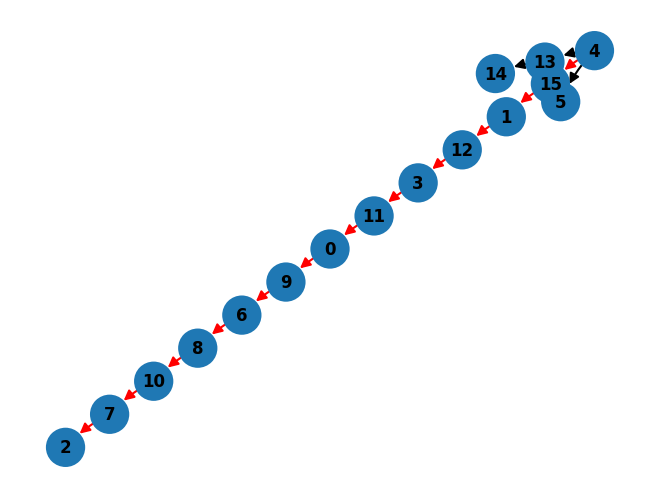

In [65]:
parse_example(graph_choices)
plt.show()

In [66]:
model.reset_hooks()
position=46 + 2  
clean_graph_choices_tokens = torch.from_numpy(dataset.tokenize(graph_choices)[0:-1]).cuda()
clean_logits_choices, clean_cache_choices = model.run_with_cache(clean_graph_choices_tokens)
print( dataset.untokenize(np.argmax(clean_logits_choices.detach().cpu(),2)[0][47:]))
corrupted_graph_choices_tokens= torch.from_numpy(dataset.tokenize(corrupted_graph_choices)[0:-1]).cuda()
corrupted_logits_choices, corrupted_cache_choices = model.run_with_cache(corrupted_graph_choices_tokens)
activation_patching_result_choices=activation_patching(model, dataset, clean_graph_choices_tokens,corrupted_graph_choices_tokens , position)#46 + 2
activation_patching_result_choices_logits=activation_patching_logits(model, dataset, clean_graph_choices_tokens,corrupted_graph_choices_tokens , position)#46 + 2
register_pathcing_result_choices= activation_patching_register(model, dataset, clean_graph_choices_tokens,corrupted_graph_choices_tokens , position,[36,38,39,41,42,44,45])

>15>1>12>3>11>0>9>6>8>10>7>2
Clean logit difference: 10.726
Corrupted logit difference: -11.838
Positive Direction: >15
Negative Direction: >5


100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


Clean logit difference: 10.726
Corrupted logit difference: -11.838
Positive Direction: >15
Negative Direction: >5


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Clean logit difference: 10.726
Corrupted logit difference: -11.838
Positive Direction: >15
Negative Direction: >5


100%|██████████| 6/6 [00:00<00:00, 66.87it/s]


In [67]:
imshow(clean_logits_choices[0][47:48],x=dataset.idx2tokens)

In [68]:
imshow(corrupted_logits_choices[0][47:48],x=dataset.idx2tokens)


In [69]:
labels, cache = get_example_cache(graph_choices, model, dataset)
get_paths(cache,labels)

{(36, '4'): ['6', '9', '0'],
 (38, ','): ['10', '8', '6', '9'],
 (39, '4'): ['3', '12', '1', '15'],
 (41, ','): ['0', '11', '3', '12'],
 (42, '4'): ['11', '3', '12', '1'],
 (44, '|'): ['1', '15', '4'],
 (47, '4'): ['2', '7', '10'],
 (48, '>15'): ['2', '7', '10'],
 (49, '>1'): ['2', '7', '10'],
 (50, '>12'): ['2', '7', '10'],
 (51, '>3'): ['2', '7', '10'],
 (52, '>11'): ['2', '7', '10'],
 (53, '>0'): ['2', '7', '10'],
 (54, '>9'): ['2', '7', '10'],
 (55, '>6'): ['2', '7', '10'],
 (56, '>8'): ['2', '7', '10'],
 (57, '>10'): ['2', '7', '10', '8'],
 (58, '>7'): ['2', '7', '10']}

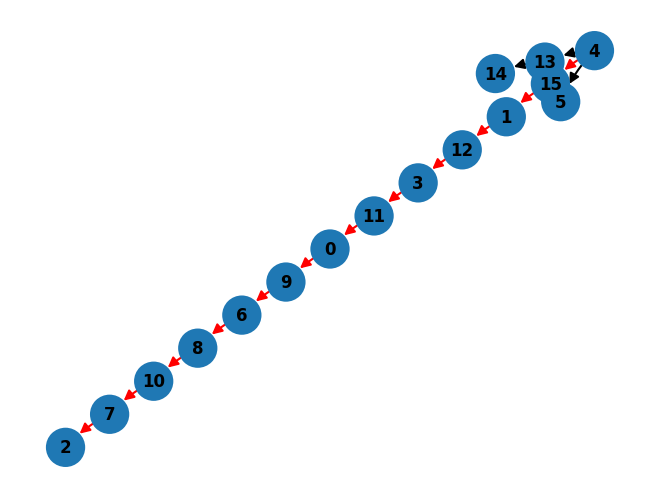

In [70]:
parse_example(graph_choices)
plt.show()

In [71]:
plot_activations(activation_patching_result_choices,clean_graph_choices_tokens, dataset)

In [72]:
plot_activations(activation_patching_result_choices_logits,clean_graph_choices_tokens, dataset)

In [73]:
imshow([register_pathcing_result_choices[1:]],x=list(range(1,model.cfg.n_layers)))

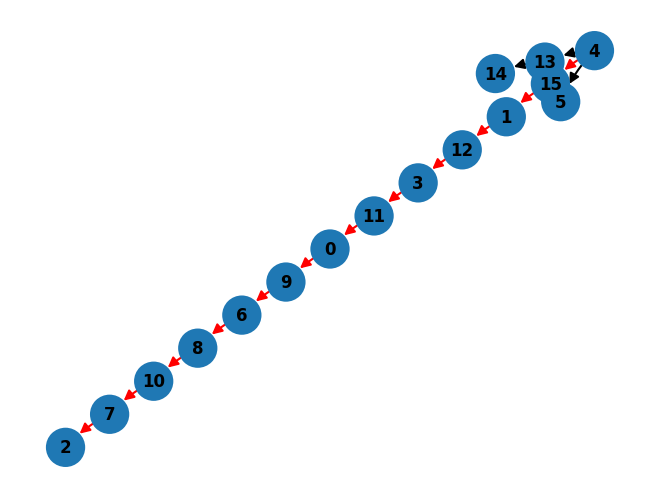

In [74]:
parse_example(graph_choices)
plt.show()

# Test example

In [75]:
random_seed = np.random.randint(1_000_000, 1_000_000_000)
graph = generate_example(n_states, random_seed, order="backward")
full_path = graph.split(":")[1].split(">")[1:]  # we ignore the first position, might need to reconsider this at some point


In [76]:
model.reset_hooks()
position=46 + 5
clean_graph_tokens = torch.from_numpy(dataset.tokenize(graph)[0:-1]).cuda()
clean_logits, clean_cache = model.run_with_cache(clean_graph_tokens)
print( dataset.untokenize(np.argmax(clean_logits.detach().cpu(),2)[0][47:]))
corrupted_graph_tokens= torch.from_numpy(dataset.tokenize(corrupted_graph)[0:-1]).cuda()
corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_graph_tokens)
activation_patching_result=activation_patching(model, dataset, clean_graph_tokens,corrupted_graph_tokens , position)#46 + 2
register_pathcing_result= activation_patching_register(model, dataset, clean_graph_tokens,corrupted_graph_tokens , position,[36,38,39,41,42,44,45])




>4>2>11
Clean logit difference: 32.201
Corrupted logit difference: -30.445
Positive Direction: ,
Negative Direction: >15


  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Clean logit difference: 32.201
Corrupted logit difference: -30.445
Positive Direction: ,
Negative Direction: >15


100%|██████████| 6/6 [00:00<00:00, 41.37it/s]


### Test 

In [77]:
def get_paths_all_layers(cache, labels, threshold=0.1,delete_not_paths=True):

    paths = {}
    for layer in range(0, 6):
        attn_pattern = cache[f"blocks.{layer}.attn.hook_pattern"]
        _, _, seq_len, _ = attn_pattern.shape

        for current_pos in range(seq_len):       
            current_token = labels[current_pos]     
            for attended_pos in range(seq_len):
                attn_value = attn_pattern[0, 0, current_pos, attended_pos]
                if attn_value > threshold:
                    attended_token = labels[attended_pos].replace(">", " ")
                    previous_token = labels[attended_pos - 1].replace(">", " ")
                    if not attended_token in special_chars and not previous_token in special_chars:
                        identifier = (current_pos, current_token)
                        if identifier in paths.keys():
                            paths[identifier].append(previous_token+f"_layer{layer}")
                        else:
                            paths[identifier] = [attended_token+f"_layer{layer}", previous_token+f"_layer{layer}"]
    if(delete_not_paths):
        paths = delete_non_paths(paths)
    return paths

In [78]:
def get_attended_pos(cache, labels,positions,layers=range(0,6), threshold=0.1):
    paths = {}
    for layer in layers:
        attn_pattern = cache[f"blocks.{layer}.attn.hook_pattern"]
        _, _, seq_len, _ = attn_pattern.shape

        for current_pos in positions:       
            current_token = labels[current_pos]     
            for attended_pos in range(seq_len):
                attn_value = attn_pattern[0, 0, current_pos, attended_pos]
                if attn_value > threshold:
                    attended_token = labels[attended_pos]
                    previous_token = labels[attended_pos - 1]
                    identifier = (current_pos, current_token)
                    if identifier in paths.keys():
                        paths[identifier].append(previous_token+f"_layer{layer}")
                    else:
                        paths[identifier] = [attended_token+f"_layer{layer}", previous_token+f"_layer{layer}"]
    return paths

In [79]:
import random
n_examples = 50
subpaths_all_backward =[]
token_positions_all_backward  =[]
all_graphs_backward =[]
for _ in range(n_examples):

    # get example
    random_seed = np.random.randint(1_000_000, 1_000_000_000)
    graph = generate_example(n_states, random_seed, order="backward")
    all_graphs_backward.append(graph)
    full_path = graph.split(":")[1].split(">")[1:]  # we ignore the first position, might need to reconsider this at some point
    full_pat_numbered =indexed_components = [f'{i}_ {component}' for i, component in enumerate(full_path)]
    graph_split = dataset.tokenize(graph)
    graph_numbered =[f'N{i}_{dataset.idx2tokens[component]}' for i, component in enumerate(graph_split)]
    # get cache
    prediction, is_correct = eval_model(model, dataset, graph)
    labels, cache = get_example_cache(prediction, model, dataset)
    
    token_positions={}
    for i, component in enumerate(graph_split):
            token_positions[dataset.idx2tokens[component]]=i
            if i>44:
                  break
    token_positions_all_backward.append(token_positions)           
    # get subpaths and reverse (as the model is backtracking)
    subpaths = get_paths(cache, labels)

    
    subpaths_all_backward.append(subpaths)

KeyboardInterrupt: 

In [ ]:
subpaths_all_backward_by_position=[]
for supath in subpaths_all_backward:
    new_subpath={}
    for key,value in supath.items():#undoing yanniks weird key think probably should just modify the subpaths function.
        new_subpath[key[0]]=value 
    subpaths_all_backward_by_position.append(new_subpath)

In [ ]:
subpaths_all_backward_by_position

[{36: ['5', '3', '1', '11'],
  39: ['3', '1', '11', '14'],
  42: ['11', '14', '13', '2'],
  44: ['1', '11', '14'],
  45: ['4', '11', '14'],
  47: ['6', '4', '11'],
  48: ['6', '4', '11'],
  49: ['6', '4', '11'],
  50: ['6', '4', '11', '14'],
  51: ['6', '4', '11', '11'],
  52: ['6', '4', '4']},
 {38: ['10', '2', '7', '9'],
  41: ['2', '7', '9', '4'],
  42: ['12', '5', '1'],
  47: ['0', '2', '7', '9'],
  48: ['0', '2', '7'],
  50: ['0', '2', '7', '7'],
  51: ['0', '2', '2'],
  49: ['2', '7', '9']},
 {39: ['3', '2', '15', '14'],
  41: ['2', '15', '14', '6'],
  42: ['12', '3', '2'],
  44: ['1', '14', '6', '11'],
  45: ['0', '12', '3'],
  47: ['4', '0', '12', '3'],
  48: ['4', '0', '12', '3'],
  49: ['4', '0', '12', '3'],
  51: ['4', '0', '12', '3'],
  53: ['4', '0', '12'],
  54: ['4', '0', '12', '3'],
  55: ['4', '0', '12'],
  56: ['4', '0', '0']},
 {36: ['5', '7', '3', '1'],
  39: ['3', '1', '15', '13'],
  42: ['11', '0', '8', '12'],
  44: ['1', '15', '13', '11'],
  47: ['14', '9', '5', 

In [ ]:
import random
n_examples = 10
graphs=
for _ in range(n_examples):

    # get example
    random_seed = np.random.randint(1_000_000, 1_000_000_000)
    graph = generate_example(n_states, random_seed, order="backward")
    full_path = graph.split(":")[1].split(">")[1:]  # we ignore the first position, might need to reconsider this at some point
    full_pat_numbered =indexed_components = [f'{i}_ {component}' for i, component in enumerate(full_path)]
    graph_split = dataset.tokenize(graph)
    graph_numbered =[f'N{i}_{dataset.idx2tokens[component]}' for i, component in enumerate(graph_split)]
    # get cache
    prediction, is_correct = eval_model(model, dataset, graph)
    labels, cache = get_example_cache(prediction, model, dataset)

    # get subpaths and reverse (as the model is backtracking)
    subpaths_all = get_paths_all_layers(cache, labels,threshold=0.05,delete_not_paths=True)
    atended_pos=get_attended_pos(cache, labels,[36,38,39,42],layers=[0,1],threshold=0.1)
    subpaths = get_paths(cache, labels)
    print(graph)
    print(subpaths)
    #print(subpaths_all)
    parse_example(graph)
    plt.show()

SyntaxError: invalid syntax (2753087978.py, line 3)

In [ ]:
def subpath_filtered(n_examples,subpath_position=36,threshold=0.3,subpath_layers_to_print=[1],print_position_token=">6",node_filter="6",not_in_subpath=True):
    for _ in range(n_examples):

        # get example
        random_seed = np.random.randint(1_000_000, 1_000_000_000)
        graph = generate_example(n_states, random_seed, order="backward")
        full_path = graph.split(":")[1].split(">")[1:]  # we ignore the first position, might need to reconsider this at some point
        full_pat_numbered =indexed_components = [f'{i}_ {component}' for i, component in enumerate(full_path)]
        graph_split = dataset.tokenize(graph)
        graph_numbered =[f'N{i}_{dataset.idx2tokens[component]}' for i, component in enumerate(graph_split)]
        node_position=-1
        for i, component in enumerate(graph_split):
            if dataset.idx2tokens[component] == print_position_token:
                node_position = i
                break
        # get cache
        prediction, is_correct = eval_model(model, dataset, graph)
        labels, cache = get_example_cache(prediction, model, dataset)

        # get subpaths and reverse (as the model is backtracking)
        subpaths = get_paths(cache, labels)
        subpaths_filter = get_attended_pos_keys(cache, labels,[subpath_position],layers=[1],threshold=threshold)
        subpaths_print = get_attended_pos_keys(cache, labels,[subpath_position],layers=subpath_layers_to_print,threshold=threshold)
        filter_node=""
        for path in subpaths_filter.values():
            filter_node =path
        if (node_filter in filter_node) ^ not_in_subpath:
            print(f'{print_position_token}_position {node_position}')
            print(f'filter_subpaths={subpaths_print}')
            print(graph_numbered)
            print(graph)
            parse_example(graph)
            plt.show()

In [80]:
subpaths_all_backward_by_position=[]
for supath in subpaths_all_backward:
    new_subpath={}
    for key,value in supath.items():#undoing yanniks weird key think probably should just modify the subpaths function.
        new_subpath[key[0]]=value 
    subpaths_all_backward_by_position.append(new_subpath)

### Test

In [81]:
from IPython.core.display import HTML, display  # Only needed if you're using IPython/Jupyter


def create_head_table(table_data, header, file_name):
    # Formatting for the HTML
    css = """
    <style type="text/css">
        .content-wrapper {
            border: 1px solid #000;
            padding: 10px;
            display: inline-block;
        }
        .header {
            font-weight: bold;
            text-align: center;
            background-color: #333; /* Dark gray background */
            color: white; /* White text */
            margin: -10px; /* Expand header to the edge of the content-wrapper */
            padding: 10px; /* Add padding to the header */
        }
        .header + .row {
            padding-top: 15px; /* Increases padding between the header and the first row */
        }
        .row {
            padding: 5px 0; /* Decreased padding for each row */
        }
    </style>
    """

    # Convert the table data to HTML with colored substrings
    html_content = '<div class="content-wrapper">'
    html_content += f'<div class="header">{header}</div>'

    for row in table_data:
        html_row = '<div class="row">'
        for text, color in row:
            if color:
                html_row += f"<span style='background-color: {color};'>{text}</span>"
            else:
                html_row += text
        html_row += '</div>'
        html_content += html_row

    html_content += '</div>'

    # Create the complete HTML with CSS
    html_str = f"<html><head>{css}</head><body>{html_content}</body></html>"
    display(HTML(html_str))


/tmp/ipykernel_6781/4113536304.py:1: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



In [82]:
random_seed = np.random.randint(1_000_000, 1_000_000_000)
graph_1 = generate_example(n_states, random_seed, order="backward")
full_path = graph.split(":")[1].split(">")[1:]  # we ignore the first position, might need to reconsider this at some point


In [ ]:
graph_1

In [83]:
def generate_bifurcated_graph():
    labels = random.sample(range(0, 15 + 1), 16)
    graph1=f"{labels[14]}>{labels[15]},{labels[13]}>{labels[14]},{labels[12]}>{labels[13]},{labels[11]}>{labels[12]},{labels[10]}>{labels[11]},{labels[9]}>{labels[10]},{labels[0]}>{labels[9]},{labels[7]}>{labels[8]},{labels[6]}>{labels[7]},{labels[5]}>{labels[6]},{labels[4]}>{labels[5]},{labels[3]}>{labels[4]},{labels[2]}>{labels[3]},{labels[1]}>{labels[2]},{labels[0]}>{labels[1]}|{labels[8]}:{labels[0]}>{labels[1]}>{labels[2]}>{labels[3]}>{labels[4]}>{labels[5]}>{labels[6]}>{labels[7]}>{labels[8]}"
    graph2=f"{labels[14]}>{labels[15]},{labels[13]}>{labels[14]},{labels[12]}>{labels[13]},{labels[11]}>{labels[12]},{labels[10]}>{labels[11]},{labels[9]}>{labels[10]},{labels[0]}>{labels[9]},{labels[7]}>{labels[8]},{labels[6]}>{labels[7]},{labels[5]}>{labels[6]},{labels[4]}>{labels[5]},{labels[3]}>{labels[4]},{labels[2]}>{labels[3]},{labels[1]}>{labels[2]},{labels[0]}>{labels[1]}|{labels[15]}:{labels[0]}>{labels[9]}>{labels[10]}>{labels[11]}>{labels[12]}>{labels[13]}>{labels[14]}>{labels[15]}"
    return graph1,graph2


In [84]:
graph_1, graph_2=generate_bifurcated_graph()

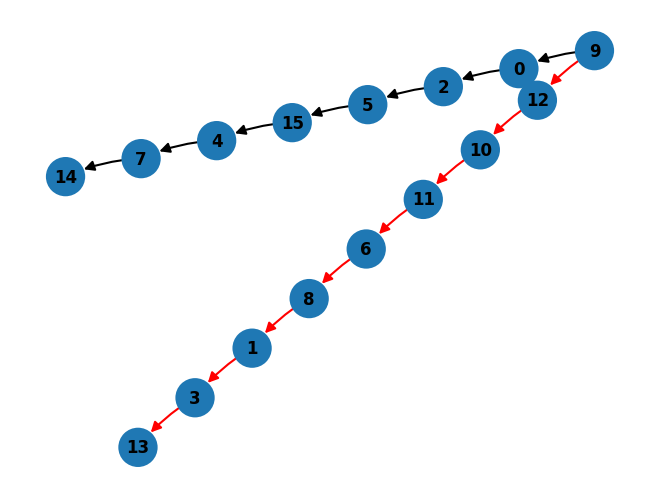

In [ ]:
parse_example(graph_1)
plt.show()

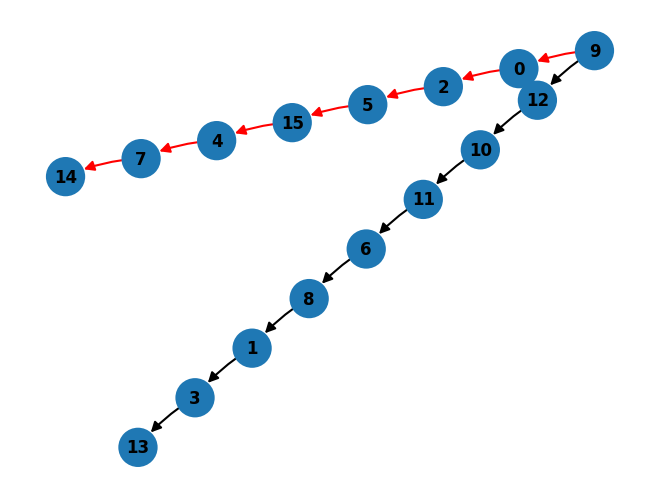

In [ ]:
parse_example(graph_2)
plt.show()

In [ ]:
model.reset_hooks()
graph_1_tokens = torch.from_numpy(dataset.tokenize(graph_1)[0:-1]).cuda()
graph_2_tokens = torch.from_numpy(dataset.tokenize(graph_2)[0:-1]).cuda()
clean_logits, graph_1_cache = model.run_with_cache(graph_1_tokens)
graph_2_logits, cache = model.run_with_cache(graph_2_tokens)
corrupted_logits = model(graph_2_tokens)
positions=[39]
def residual_stream_patching_hook(resid_pre,hook,positions):
        graph_1_resid_pre = graph_1_cache[hook.name]
        print(resid_pre.shape)
        for position in positions:
            resid_pre[:, position, :] = graph_1_resid_pre[:, position, :]
        return resid_pre
temp_hook_fn = partial(residual_stream_patching_hook, positions=positions)
model.add_hook("blocks.1.attn.hook_z", temp_hook_fn)

patched_logits, patched_cache = model.run_with_cache(graph_2_tokens)
model.reset_hooks()
labels_graph_2,_ = get_example_cache(graph_2, model, dataset)
subpaths = get_paths(cache, labels_graph_2)
subpaths_pathched = get_paths(patched_cache, labels_graph_2)
print(subpaths)
print(subpaths_pathched)

torch.Size([1, 65, 1, 128])
{(41, ','): ['2', '0', '9'], (42, '9'): ['11', '10', '12'], (44, '|'): ['1', '8', '6', '11'], (45, '14'): ['4', '15', '5'], (47, '9'): ['14', '7', '4'], (48, '>0'): ['14', '7', '4'], (49, '>2'): ['14', '7', '4'], (50, '>5'): ['14', '7', '4'], (51, '>15'): ['14', '7', '4'], (52, '>4'): ['14', '7', '4', '15'], (53, '>7'): ['14', '7', '4', '4'], (54, '>14'): ['14', '7', '7']}
{(41, ','): ['2', '0', '9'], (42, '9'): ['11', '10', '12'], (44, '|'): ['1', '8', '6', '11'], (45, '14'): ['4', '15', '5'], (47, '9'): ['14', '7', '4'], (48, '>0'): ['14', '7', '4'], (49, '>2'): ['14', '7', '4'], (50, '>5'): ['14', '7', '4'], (51, '>15'): ['14', '7', '4'], (52, '>4'): ['14', '7', '4', '15'], (53, '>7'): ['14', '7', '4', '4'], (54, '>14'): ['14', '7', '7']}


In [ ]:
pos = 47
labels, cache = get_example_cache(graph_2, model, dataset)
table_data = []
for i in range(6):
    pattern = patched_cache[f"blocks.{i}.attn.hook_pattern"][0][0][pos].tolist()[:pos+1]
    pattern = [f"rgba(220, 20, 60, {min(1, p*1.4):.2f})" for p in pattern]
    row = list(zip(labels, pattern))
    table_data.append([(f"Layer {i+1}: ", None)]+row)

# Header for the content
header = "Attention From First Token Of The Path"

create_head_table(table_data, header, "images/backchaining_main.png")

In [ ]:
patched_cache_list=[]
for i in range(100):
    graph_1, graph_2=generate_bifurcated_graph()
    model.reset_hooks()
    graph_1_tokens = torch.from_numpy(dataset.tokenize(graph_1)[0:-1]).cuda()
    graph_2_tokens = torch.from_numpy(dataset.tokenize(graph_2)[0:-1]).cuda()
    clean_logits, graph_1_cache = model.run_with_cache(graph_1_tokens)
    graph_2_logits, cache = model.run_with_cache(graph_2_tokens)
    corrupted_logits = model(graph_2_tokens)
    positions=[47]
    def residual_stream_patching_hook(resid_pre,hook,positions):
            graph_1_resid_pre = graph_1_cache[hook.name]
            for position in positions:
                resid_pre[:, position, :] = graph_1_resid_pre[:, position, :]
            return resid_pre
    temp_hook_fn = partial(residual_stream_patching_hook, positions=positions)
    model.add_hook("blocks.1.attn.hook_z", temp_hook_fn)

    patched_logits, patched_cache = model.run_with_cache(graph_2_tokens)
    model.reset_hooks()
    patched_cache_list.append(patched_cache)


In [ ]:
pos = 47
order_graph_2='14>15,13>14,12>13,11>12,10>11,9>10,0>9,7>8,6>7,5>6,4>5,3>4,2>3,1>2,0>1|15:0>9>10>11>12>13>14>15'
labels, _ = get_example_cache(order_graph_2, model, dataset)
table_data = []
for i in range(6):
    total_cache=torch.zeros_like(patched_cache_list[0][f"blocks.{i}.attn.hook_pattern"][0][0][pos])
    for patched_cache in patched_cache_list:
        total_cache+=patched_cache[f"blocks.{i}.attn.hook_pattern"][0][0][pos]

    pattern = nn.functional.softmax(total_cache).tolist()[:pos+1]
    pattern = [f"rgba(220, 20, 60, {min(1, p*1.4):.2f})" for p in pattern]
    row = list(zip(labels, pattern))
    table_data.append([(f"Layer {i+1}: ", None)]+row)

# Header for the content
header = "Attention From First Token Of The Path"

create_head_table(table_data, header, "images/backchaining_main.png")

/tmp/ipykernel_5147/3323770657.py:10: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



In [ ]:
cache

In [ ]:
imshow(nn.functional.softmax(patched_logits[0])-nn.functional.softmax(clean_logits[0]),x=dataset.idx2tokens)

### Test

In [85]:
model.reset_hooks()
graph_1_tokens = torch.from_numpy(dataset.tokenize(graph_1)[0:-1]).cuda()
graph_2_tokens = torch.from_numpy(dataset.tokenize(graph_2)[0:-1]).cuda()
clean_logits, graph_1_cache = model.run_with_cache(graph_1_tokens)
graph_2_logits, cache = model.run_with_cache(graph_2_tokens)
corrupted_logits = model(graph_2_tokens)
def residual_stream_patching_hook(resid_pre,hook,position,position_2):
        graph_1_resid_pre = graph_1_cache[hook.name]
        print(resid_pre.shape)
        resid_pre[:, position, :] = graph_1_resid_pre[:, position_2, :]
        return resid_pre
temp_hook_fn = partial(residual_stream_patching_hook, position=47, position_2=41)
model.add_hook("blocks.1.attn.hook_z", temp_hook_fn)

patched_logits, patched_cache = model.run_with_cache(graph_2_tokens)
model.reset_hooks()
labels_graph_2,_ = get_example_cache(graph_2, model, dataset)
subpaths = get_paths(cache, labels_graph_2)
subpaths_pathched = get_paths(patched_cache, labels_graph_2)
print(subpaths)
print(subpaths_pathched)

torch.Size([1, 65, 1, 128])
{(38, ','): ['10', '15', '4'], (39, '5'): ['3', '14', '10'], (41, ','): ['2', '1', '9', '13'], (44, '|'): ['1', '9', '13', '6'], (47, '4'): ['11', '8', '7', '3'], (48, '>15'): ['11', '8', '7', '3'], (49, '>10'): ['11', '8', '7', '3'], (50, '>14'): ['11', '8', '7', '3'], (51, '>3'): ['11', '8', '7'], (52, '>7'): ['11', '8', '7', '3'], (53, '>8'): ['11', '8', '7'], (54, '>11'): ['11', '8', '8']}
{(38, ','): ['10', '15', '4'], (39, '5'): ['3', '14', '10'], (41, ','): ['2', '1', '9', '13'], (44, '|'): ['1', '9', '13', '6'], (47, '4'): ['11', '8', '9', '13'], (48, '>15'): ['11', '8', '7', '3'], (49, '>10'): ['11', '8', '7', '3'], (50, '>14'): ['11', '8', '7', '3'], (51, '>3'): ['11', '8', '7'], (52, '>7'): ['11', '8', '7', '3'], (53, '>8'): ['11', '8', '7'], (54, '>11'): ['11', '8', '8']}


In [ ]:
imshow((patched_logits[0]-graph_2_logits[0])[47:48],x=dataset.idx2tokens)

In [ ]:
imshow((graph_2_logits[0])[47:48],x=dataset.idx2tokens)

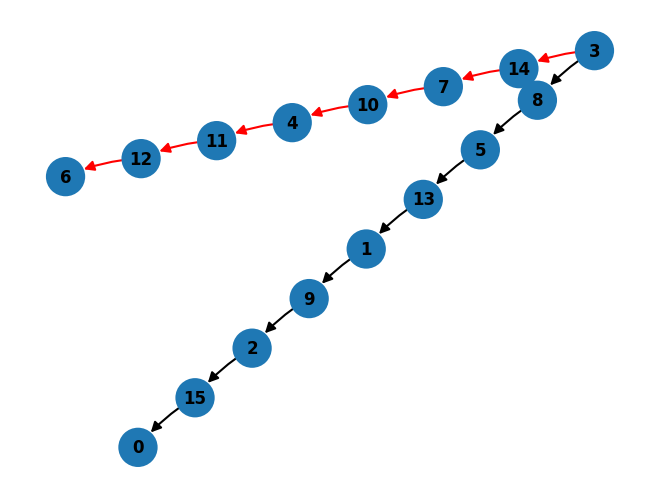

In [ ]:
parse_example(graph_2)
plt.show()

In [ ]:
pos = 47
labels, cache = get_example_cache(graph_2, model, dataset)
table_data = []
for i in range(6):
    pattern = patched_cache[f"blocks.{i}.attn.hook_pattern"][0][0][pos].tolist()[:pos+1]
    pattern = [f"rgba(220, 20, 60, {min(1, p*1.4):.2f})" for p in pattern]
    row = list(zip(labels, pattern))
    table_data.append([(f"Layer {i+1}: ", None)]+row)

# Header for the content
header = "Attention From First Token Of The Path"

create_head_table(table_data, header, "images/backchaining_main.png")

In [ ]:
pos = 47
labels, cache = get_example_cache(graph_2, model, dataset)
table_data = []
for i in range(6):
    pattern = cache[f"blocks.{i}.attn.hook_pattern"][0][0][pos].tolist()[:pos+1]
    pattern = [f"rgba(220, 20, 60, {min(1, p*1.4):.2f})" for p in pattern]
    row = list(zip(labels, pattern))
    table_data.append([(f"Layer {i+1}: ", None)]+row)

# Header for the content
header = "Attention From First Token Of The Path"

create_head_table(table_data, header, "images/backchaining_main.png")

Test

In [ ]:
#graph_test_1='14>15,13>14,12>13,11>12,10>11,9>10,0>9,7>8,6>7,5>6,4>5,3>4,2>3,1>2,0>1|15:0>9>10>11>12>13>14>15'
#graph_test_1='7>2,10>7,8>10,6>8,9>6,11>0,0>9,12>3,3>1,1>12,13>14,15>1,4>13,4>15,5>11,4>5|2:4>15>1>12>3>0>9>6>8>10>7>2'
graph_test_1='7>2,10>7,8>10,6>8,9>6,11>9,3>11,12>3,1>12,13>14,15>1,4>13,4>15,5>0,4>5|2:4>15>1>12>3>11>9>6>8>10>7>2'

In [ ]:
graph_test_duplicated='7>2,10>7,8>10,6>8,9>6,11>9,3>11,12>3,1>12,13>14,15>1,4>13,4>15,13>0,4>13|2:4>15>1>12>3>11>9>6>8>10>7>2'

In [ ]:
graph_test_triplicated='8>7,11>8,3>11,12>3,1>12,15>1,4>13,4>15,13>14,13>0,13>10,13>2,4>13,4>13,4>13|7:4>15>1>12>3>11>8>7'

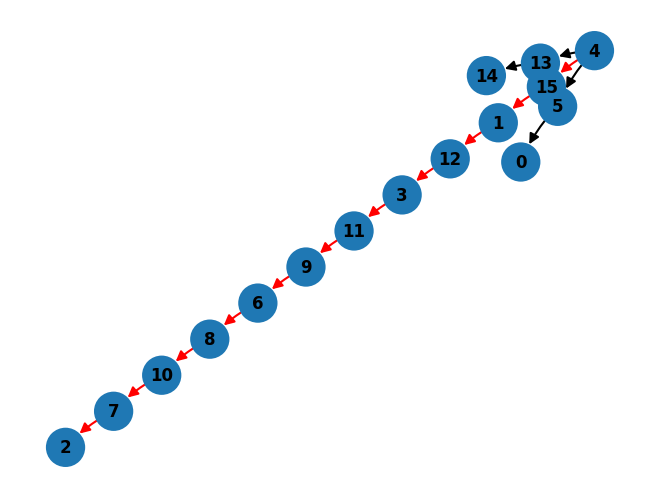

In [ ]:
parse_example(graph_test_1)
plt.show()

In [ ]:
parse_example(graph_test_duplicated)
plt.show()

In [ ]:
graph_test_duplicated_tokens = torch.from_numpy(dataset.tokenize(graph_test_duplicated)[0:-1]).cuda()
duplicated_logits, duplicated_cache = model.run_with_cache(graph_test_duplicated_tokens)
graph_test_1_tokens = torch.from_numpy(dataset.tokenize(graph_test_1)[0:-1]).cuda()
test_1_logits, graph_1_cache = model.run_with_cache(graph_test_1_tokens)
graph_test_triplicated_tokens = torch.from_numpy(dataset.tokenize(graph_test_triplicated)[0:-1]).cuda()
triplicated_logits, triplicated_cache = model.run_with_cache(graph_test_triplicated_tokens)


In [ ]:
imshow(triplicated_logits[0],x=dataset.idx2tokens)

In [ ]:
imshow(duplicated_logits[0],x=dataset.idx2tokens)

In [ ]:
imshow(test_1_logits[0],x=dataset.idx2tokens)

### Intervention plot

In [86]:
def generate_tree_with_limit(n, depth, current_node, current_depth, max_nodes, parent_node=None):
    if current_depth == depth or max_nodes <= 0:
        return []

    edges = []
    num_branches = random.randint(2, 5)

    for i in range(num_branches):
        child_node = current_node + i + 1
        edges.append(f"{current_node}>{child_node}")
        child_subtree_nodes = 1 + generate_tree_with_limit(
            n, depth, child_node, current_depth + 1, max_nodes - 1, current_node
        )
        max_nodes -= child_subtree_nodes

    return edges

In [87]:
def sample_tree_graph_secondary_path(
    n_states: int,
    path_length: int,
    rng: np.random.Generator,
    is_binary: bool = True,
    second_path_min_lenght: int = None,
):
    """Generate a random tree with the specified params

    Args:
        n_states (int): Number of nodes in tree
        path_length (int): Length of path
        rng (np.random.Generator): Random number generator
        is_binary (bool, optional): Whether or not each node can have a 
        max of two children. Defaults to False.

    Returns:
        Tuple[nx.DiGraph, int, int]: Return the graph, the root, and the goal node
    """
    # Create adjacency matrix
    adj_matrix = np.zeros((n_states, n_states))
    source_node = None
    destination_node = None
    second_source = None
    second_path_destination_node = None
    nodes = [i for i in range(n_states)]
    nodes_in_tree = []
    intermediate_node = None
    # Generate path of defined 'path_length'
    for i in range(path_length + 1):  # '+ 1' as we have to sample the source node first 
        # sample example and remove it from the list of nodes
        sample_node = rng.choice(nodes, 1)[0]
        nodes.remove(sample_node)
        nodes_in_tree.append(sample_node)
        # construct the edge and add it to the edge list
        if source_node is None:
            source_node = sample_node
        else:
            adj_matrix[intermediate_node, sample_node] = 1
        intermediate_node = sample_node
    destination_node = intermediate_node
    # Add other nodes until requested 'n_states'
    nodes_in_tree.remove(destination_node)  # remove destination to ensure we don't increase path length
    if second_path_min_lenght is not None and len(nodes)>=second_path_min_lenght:
        for i in range(second_path_min_lenght):
            sample_node = rng.choice(nodes, 1)[0]
            nodes.remove(sample_node)
            nodes_in_tree.append(sample_node)
            if second_source is None:
                adj_matrix[source_node, sample_node] = 1
                second_source = sample_node
            else:
                adj_matrix[intermediate_node, sample_node] = 1
            intermediate_node = sample_node  
        second_path_destination_node = intermediate_node      
             
    for n in nodes:
        # Sample a position in the tree
        if is_binary:
            valid_parents = [node for node in nodes_in_tree if adj_matrix[node].sum() < 2]
        else:
            valid_parents = nodes_in_tree
        connection_node = rng.choice(valid_parents, 1)[0]
        # Integrate node
        adj_matrix[connection_node, n] = 1
        nodes_in_tree.append(n)
        if connection_node == second_path_destination_node:
            second_path_destination_node = n

    # Create networkx object
    tree = nx.DiGraph(incoming_graph_data=adj_matrix)
    return tree, source_node,destination_node, second_source,second_path_destination_node

In [96]:
def topological_sort_edges(graph: nx.DiGraph):
    """Takes in a DAG in NetworkX format, and creates an edgelist where 
    the edges are topologically sorted by the first node in each edge.

    Args:
        graph (nx.DiGraph): Input graph

    Returns:
        List[Tuple[int, int]]: Sorted edgelist
    """
    try:
        node_order = list(nx.topological_sort(graph))
        sorted_edges = []
        for i in range(len(node_order) - 1):
            for j in range(i + 1, len(node_order)):
                if graph.has_edge(node_order[i], node_order[j]):
                    sorted_edges.append((node_order[i], node_order[j]))
        return sorted_edges
    except nx.NetworkXUnfeasible:
        print("The graph is not a directed acyclic graph (DAG)!")
        return None


def shortest_path(
    edgelist,
    n_nodes: int,
    start: int,
    end: int
):
    """Does BFS over graph to find the shortest path from
    start to end

    Args:
        edgelist (List[Tuple[int, int]]): List of edges
        n_nodes (int): Total number of nodes in graph
        start (int): First node in path
        end (int): Last node in path

    Returns:
        Returns a list of nodes in the path if found, returns -1 otherwise
    """
    # BFS algorithm to extract the shortest path to a goal node
    visited = np.zeros((n_nodes,), dtype=bool)
    queue = [(start, [start],  0)]  # (node, distance)
    while queue:
        current_node, path, current_distance = queue.pop(0)
        if current_node == end:
            return path
        if not visited[current_node]:
            visited[current_node] = True
            neighbors = [edgelist[i][1] for i in range(len(edgelist)) if edgelist[i][0] == current_node]
            for neighbor in neighbors:
                if not visited[neighbor]:
                    copy_path = path.copy()
                    copy_path.append(neighbor)
                    queue.append((neighbor, copy_path, current_distance + 1))
    return -1  # Path not found


In [97]:
def generate_example_secondary_path(
    n_states: int,
    seed: int,
    order: str = "random",
    path_length: int = None,
    return_all_leafs: bool = False,
    is_binary: bool = True,
    second_path_min_lenght= None,
    
):
    """Generates a random example involving an edgelist of a tree, a leaf node, and a path from the root node to the leaf
    Args:
        n_states (int): Number of nodes in graph
        seed (int): Seed for rng that generates graph
        order (str, optional): The order of the edges in the edgelist. Defaults to "random".
        path_length (int, optional): Distance between root and goal in example. Defaults to None.
        return_all_leafs (bool, optional): Whether to return all possible path. Defaults to False.
        is_binary (bool, optional): Whether or not the tree should be binary. Defaults to False.

    Returns:
        Returns single string by default
        Returns a list of all possible example strings if return_all_leafs is True
    """
    assert n_states >= 2
    assert path_length is None or path_length < n_states
    assert order in ["forward", "backward", "random"]
    # Sample tree and path with path_length
    rng = np.random.default_rng(seed=seed)
    if path_length is None:
        path_length = rng.integers(1, n_states-second_path_min_lenght)
    graph, start_node, goal,second_path_start,second_path_goal = sample_tree_graph_secondary_path(n_states, path_length, rng, is_binary,second_path_min_lenght)
    edgelist = topological_sort_edges(graph)
    if order == "random":
        rng.shuffle(edgelist)
    elif order == "backward":
        edgelist = edgelist[::-1]
    # Create all possible examples from edgelist
    source_nodes = set([source for source, target in edgelist])
    target_nodes = set([target for source, target in edgelist])
    leaf_nodes = target_nodes - source_nodes
    # Sample all possible paths
    examples = {}
    for end_node in list(leaf_nodes):
        path = shortest_path(edgelist, n_states, start_node, end_node)
        # Convert to a series of tokens
        string = ",".join([f"{i}>{j}" for i, j in edgelist])
        string = string + f"|{end_node}:"
        string = string + ">".join([str(p) for p in path])
        examples[end_node] = string
    # Return all leafs if specified
    if return_all_leafs:
        return list(examples.values())
    elif second_path_goal is not None:
        return examples[goal],examples[second_path_goal],second_path_start,second_path_goal 
    else:
        return examples[goal],None,None,None 


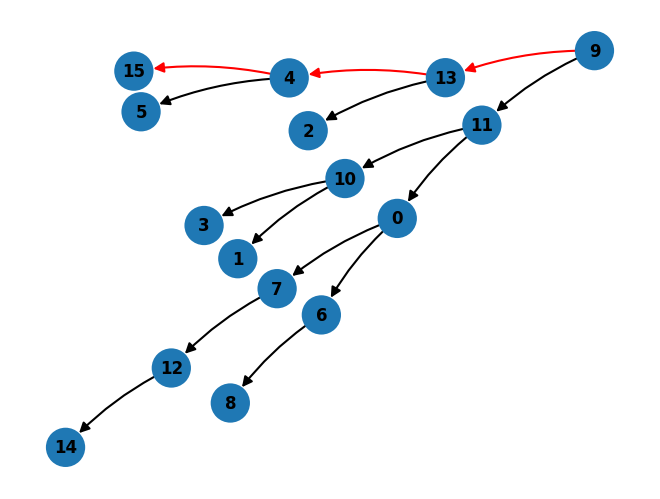

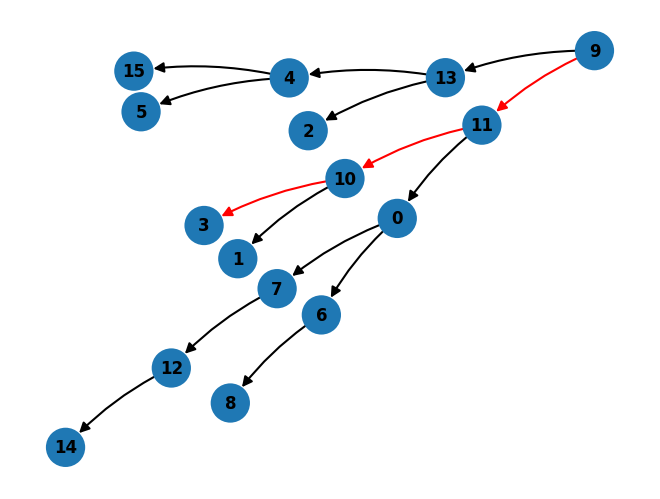

In [98]:
random_seed = np.random.randint(1_000_000, 1_000_000_000)
graph_1,graph_2,second_path_start,second_path_goal = generate_example_secondary_path(n_states, random_seed, order="backward",second_path_min_lenght=3)
parse_example(graph_1)
plt.show()
parse_example(graph_2)
plt.show()


### Intervention plot

In [99]:
model.reset_hooks()
graph_1_tokens = torch.from_numpy(dataset.tokenize(graph_1)[0:-1]).cuda()
graph_2_tokens = torch.from_numpy(dataset.tokenize(graph_2)[0:-1]).cuda()
graph_1_logits, graph_1_cache = model.run_with_cache(graph_1_tokens)
graph_2_logits, cache = model.run_with_cache(graph_2_tokens)
corrupted_logits = model(graph_2_tokens)
def residual_stream_patching_hook(resid_pre,hook,position,position_2):
        graph_1_resid_pre = graph_1_cache[hook.name]
        resid_pre[:, position, :] = graph_1_resid_pre[:, position_2, :]
        return resid_pre
temp_hook_fn = partial(residual_stream_patching_hook, position=47, position_2=47)
model.add_hook("blocks.1.attn.hook_z", temp_hook_fn)
patched_logits, patched_cache = model.run_with_cache(graph_2_tokens)
model.reset_hooks()
index_first_path=np.argmax(patched_logits[0,47:48].detach().cpu())
index_second_path=dataset.idx2tokens.index(f">{second_path_start}")


18

In [100]:
print(graph_2_logits[0,47:48,index_second_path]-patched_logits[0,47:48,index_first_path])

tensor([0.1927], device='cuda:0', grad_fn=<SubBackward0>)


In [101]:
imshow((patched_logits[0]-graph_2_logits[0])[47:48],x=dataset.idx2tokens)

In [ ]:
for i in range(100):
        random_seed = np.random.randint(1_000_000, 1_000_000_000)
        graph_1,graph_2,second_path_start,second_path_goal = generate_example_secondary_path(n_states, random_seed, order="backward",second_path_min_lenght=3)
        for layer in range(model.cfg.n_layers) :
                model.reset_hooks()
                graph_1_tokens = torch.from_numpy(dataset.tokenize(graph_1)[0:-1]).cuda()
                graph_2_tokens = torch.from_numpy(dataset.tokenize(graph_2)[0:-1]).cuda()
                graph_1_logits, graph_1_cache = model.run_with_cache(graph_1_tokens)
                graph_2_logits, cache = model.run_with_cache(graph_2_tokens)
                corrupted_logits = model(graph_2_tokens)
                def residual_stream_patching_hook(resid_pre,hook,position,position_2):
                        graph_1_resid_pre = graph_1_cache[hook.name]
                        resid_pre[:, position, :] = graph_1_resid_pre[:, position_2, :]
                        return resid_pre
                temp_hook_fn = partial(residual_stream_patching_hook, position=47, position_2=47)
                model.add_hook("blocks.1.attn.hook_z", temp_hook_fn)
                patched_logits, patched_cache = model.run_with_cache(graph_2_tokens)
                model.reset_hooks()
                index_first_path=np.argmax(patched_logits[0,47:48].detach().cpu())
                index_second_path=dataset.idx2tokens.index(f">{second_path_start}")

In [185]:
cache

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_re

In [256]:
random_seed = np.random.randint(1_000_000, 1_000_000_000)
graph_1,graph_2,second_path_start,second_path_goal = generate_example_secondary_path(n_states, random_seed, order="backward",second_path_min_lenght=3)
results=np.zeros(model.cfg.n_layers)
for layer in range(model.cfg.n_layers) :
    model.reset_hooks()
    graph_1_tokens = torch.from_numpy(dataset.tokenize(graph_1)[0:-1]).cuda()
    graph_2_tokens = torch.from_numpy(dataset.tokenize(graph_2)[0:-1]).cuda()
    graph_1_logits, graph_1_cache = model.run_with_cache(graph_1_tokens)
    graph_2_logits, cache = model.run_with_cache(graph_2_tokens)
    corrupted_logits = model(graph_2_tokens)
    def residual_stream_patching_hook(resid_pre,hook,position,position_2):
            graph_1_resid_pre = graph_1_cache[hook.name]
            resid_pre[:, position, :] = graph_1_resid_pre[:, position_2, :]
            return resid_pre
    temp_hook_fn = partial(residual_stream_patching_hook, position=47, position_2=47)
    #model.add_hook(f"blocks.{layer}.attn.hook_z", temp_hook_fn)
    model.add_hook(f"blocks.{layer}.hook_attn_out", temp_hook_fn)
    patched_logits, patched_cache = model.run_with_cache(graph_2_tokens)
    model.reset_hooks()
    index_first_path=np.argmax(patched_logits[0,47:48].detach().cpu())
    index_second_path=dataset.idx2tokens.index(f">{second_path_start}")
    diference_probabilities_clean=torch.softmax(graph_2_logits[0,47:48],1)[0,index_first_path] -torch.softmax(graph_2_logits[0,47:48],1)[0,index_second_path]
    diference_probabilities_patched=torch.softmax(patched_logits[0,47:48],1)[0,index_first_path]-torch.softmax(patched_logits[0,47:48],1)[0,index_second_path]
    results[layer]=diference_probabilities_clean-diference_probabilities_patched
px.line(results)   

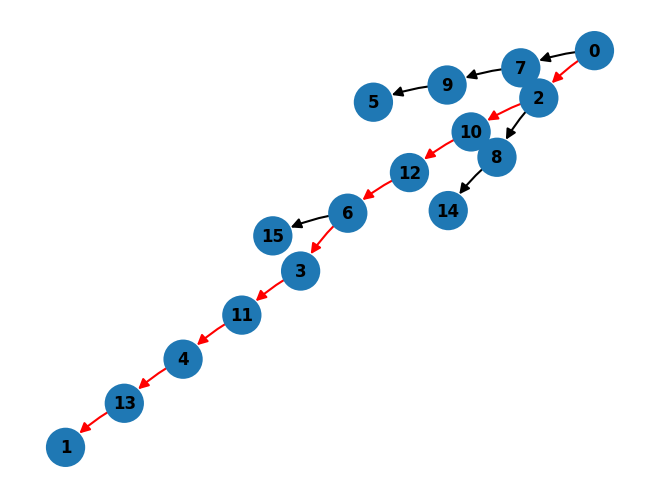

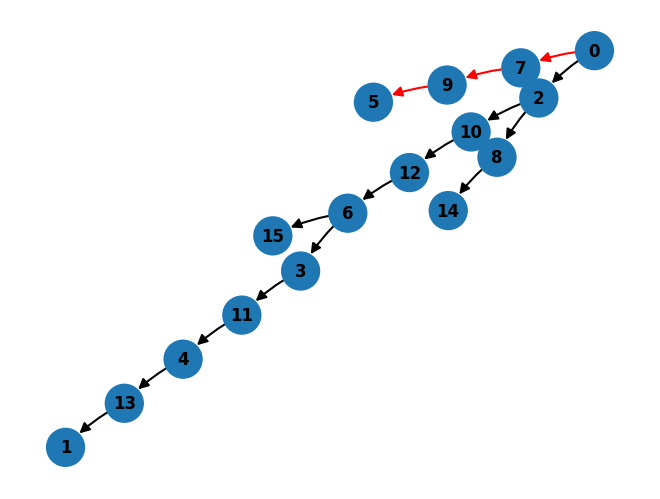

In [257]:
parse_example(graph_1)
plt.show()
parse_example(graph_2)
plt.show()

In [258]:
results=np.zeros(model.cfg.n_layers)
for layer in range(model.cfg.n_layers) :
    model.reset_hooks()
    graph_1_tokens = torch.from_numpy(dataset.tokenize(graph_1)[0:-1]).cuda()
    graph_2_tokens = torch.from_numpy(dataset.tokenize(graph_2)[0:-1]).cuda()
    graph_1_logits, graph_1_cache = model.run_with_cache(graph_1_tokens)
    graph_2_logits, cache = model.run_with_cache(graph_2_tokens)
    corrupted_logits = model(graph_2_tokens)
    def residual_stream_patching_hook(resid_pre,hook,position,position_2):
            graph_1_resid_pre = graph_1_cache[hook.name]
            resid_pre[:, position, :] = graph_1_resid_pre[:, position_2, :]
            return resid_pre
    temp_hook_fn = partial(residual_stream_patching_hook, position=47, position_2=47)
    #model.add_hook(f"blocks.{layer}.attn.hook_z", temp_hook_fn)
    model.add_hook(f"blocks.{layer}.hook_attn_out", temp_hook_fn)
    patched_logits, patched_cache = model.run_with_cache(graph_2_tokens)
    model.reset_hooks()
    index_first_path=np.argmax(patched_logits[0,47:48].detach().cpu())
    index_second_path=dataset.idx2tokens.index(f">{second_path_start}")
    diference_probabilities_clean=torch.softmax(graph_2_logits[0,47:48],1)[0,index_first_path] -torch.softmax(graph_2_logits[0,47:48],1)[0,index_second_path]
    diference_probabilities_patched=torch.softmax(patched_logits[0,47:48],1)[0,index_first_path]-torch.softmax(patched_logits[0,47:48],1)[0,index_second_path]
    results[layer]=diference_probabilities_clean-diference_probabilities_patched
px.line(results) 



In [214]:
register_patching_result_backwards_test = activation_patching_register(model, dataset, graph_1_tokens, graph_2_tokens, 46 + 2 ,[36,38,39,41,42,44,45])

Clean logit difference: -3.069
Corrupted logit difference: -22.790
Positive Direction: >1
Negative Direction: >3


  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 42.82it/s]


In [215]:
register_patching_result_backwards_test

tensor([1.0000e+00, 7.8340e-05, 3.8415e-04, 3.6887e-04, 9.4897e-04, 5.3281e-04],
       device='cuda:0', grad_fn=<CopySlices>)

In [200]:
imshow(graph_1_logits[0],x=dataset.idx2tokens)

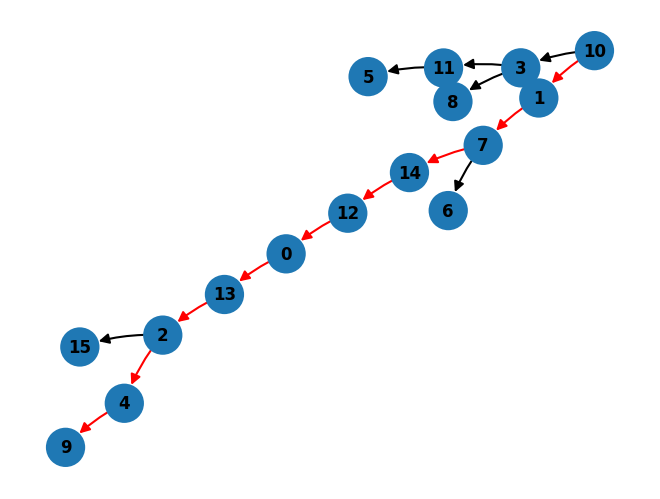

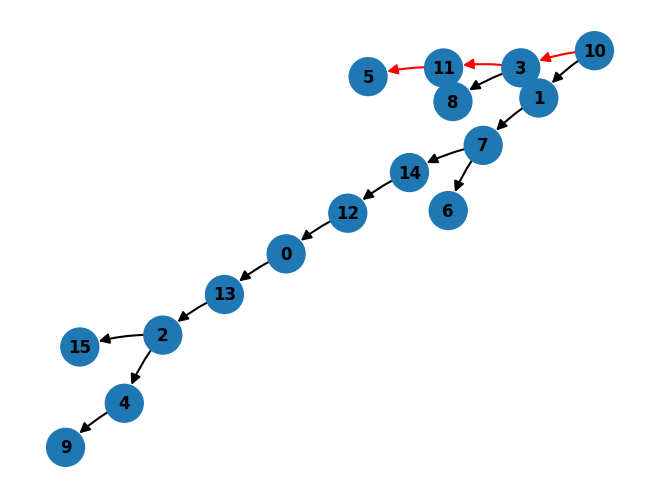

In [199]:
parse_example(graph_1)
plt.show()
parse_example(graph_2)
plt.show()

In [260]:
results=np.zeros(model.cfg.n_layers)
for i in range(100):
    random_seed = np.random.randint(1_000_000, 1_000_000_000)
    graph_1,graph_2,second_path_start,second_path_goal = generate_example_secondary_path(n_states, random_seed, order="backward",second_path_min_lenght=3)
    for layer in range(model.cfg.n_layers) :
        model.reset_hooks()
        graph_1_tokens = torch.from_numpy(dataset.tokenize(graph_1)[0:-1]).cuda()
        graph_2_tokens = torch.from_numpy(dataset.tokenize(graph_2)[0:-1]).cuda()
        graph_1_logits, graph_1_cache = model.run_with_cache(graph_1_tokens)
        graph_2_logits, cache = model.run_with_cache(graph_2_tokens)
        corrupted_logits = model(graph_2_tokens)
        def residual_stream_patching_hook(resid_pre,hook,position,position_2):
                graph_1_resid_pre = graph_1_cache[hook.name]
                resid_pre[:, position, :] = graph_1_resid_pre[:, position_2, :]
                return resid_pre
        temp_hook_fn = partial(residual_stream_patching_hook, position=47, position_2=47)
        #model.add_hook(f"blocks.{layer}.attn.hook_z", temp_hook_fn)
        model.add_hook(f"blocks.{layer}.hook_attn_out", temp_hook_fn)
        patched_logits, patched_cache = model.run_with_cache(graph_2_tokens)
        model.reset_hooks()
        index_first_path=np.argmax(patched_logits[0,47:48].detach().cpu())
        index_second_path=dataset.idx2tokens.index(f">{second_path_start}")
        diference_probabilities_clean=torch.softmax(graph_2_logits[0,47:48],1)[0,index_first_path] -torch.softmax(graph_2_logits[0,47:48],1)[0,index_second_path]
        diference_probabilities_patched=torch.softmax(patched_logits[0,47:48],1)[0,index_first_path]-torch.softmax(patched_logits[0,47:48],1)[0,index_second_path]
        results[layer]+=diference_probabilities_clean-diference_probabilities_patched
px.line(results/100)   

In [262]:
results=np.zeros((model.cfg.n_layers,13))
for lenght in range(13):
    for j in range(100):
        random_seed = np.random.randint(1_000_000, 1_000_000_000)
        graph_1,graph_2,second_path_start,second_path_goal = generate_example_secondary_path(n_states, random_seed, order="backward",second_path_min_lenght=3,path_length=lenght)
        for layer in range(model.cfg.n_layers) :
            model.reset_hooks()
            graph_1_tokens = torch.from_numpy(dataset.tokenize(graph_1)[0:-1]).cuda()
            graph_2_tokens = torch.from_numpy(dataset.tokenize(graph_2)[0:-1]).cuda()
            graph_1_logits, graph_1_cache = model.run_with_cache(graph_1_tokens)
            graph_2_logits, cache = model.run_with_cache(graph_2_tokens)
            corrupted_logits = model(graph_2_tokens)
            def residual_stream_patching_hook(resid_pre,hook,position,position_2):
                    graph_1_resid_pre = graph_1_cache[hook.name]
                    resid_pre[:, position, :] = graph_1_resid_pre[:, position_2, :]
                    return resid_pre
            temp_hook_fn = partial(residual_stream_patching_hook, position=47, position_2=47)
            #model.add_hook(f"blocks.{layer}.attn.hook_z", temp_hook_fn)
            model.add_hook(f"blocks.{layer}.hook_attn_out", temp_hook_fn)
            patched_logits, patched_cache = model.run_with_cache(graph_2_tokens)
            model.reset_hooks()
            index_first_path=np.argmax(patched_logits[0,47:48].detach().cpu())
            index_second_path=dataset.idx2tokens.index(f">{second_path_start}")
            diference_probabilities_clean=torch.softmax(graph_2_logits[0,47:48],1)[0,index_first_path] -torch.softmax(graph_2_logits[0,47:48],1)[0,index_second_path]
            diference_probabilities_patched=torch.softmax(patched_logits[0,47:48],1)[0,index_first_path]-torch.softmax(patched_logits[0,47:48],1)[0,index_second_path]
            results[layer,lenght]+=diference_probabilities_clean-diference_probabilities_patched
px.line(results/100)   

KeyError: 7